<a href="https://colab.research.google.com/github/mudita11/Covid-visual/blob/main/CWT_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from dateutil.parser import parse
from collections import Counter
import nltk
import string
import re
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords
from nltk.corpus import wordnet
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, roc_curve, pairwise_distances, roc_auc_score, precision_score, recall_score, precision_recall_curve, mean_squared_error
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.options.display.max_rows = 50
pd.options.display.max_columns = 50

In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def count_unique(col, txt, sort_index):
    '''
    Count the unique values in column
    Returns sorted count values
    '''
    unique_val = np.unique(col, return_counts = True)
    a = unique_val[0]
    b = unique_val[1]
    unique_val_all = list(zip(a, b))
    print('Number of unique {} {}'.format(txt, len(unique_val_all)))
    sorted_unique_val_all = sorted(unique_val_all, key=lambda t: t[sort_index], reverse=True)
    return a, b, sorted_unique_val_all

In [ ]:
df = pd.read_csv('London_reviews.csv', header=None)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (0,1,3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,NaN,parse_count,restaurant_name,rating_review,sample,review_id,title_review,review_preview,review_full,date,city,url_restaurant,author_id
1,0.0,1,Cocotte_Notting_Hill,5.0,Positive,review_771556136,JUST PERFECT,I was away for couple of months and I am so h...,I was away for couple of months and I am so ha...,"September 23, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_0
2,1.0,2,Cocotte_Notting_Hill,5.0,Positive,review_771555883,"Quality food, Food travels well, Excellent cus...",I recently ordered over the phone from Cocotte...,I recently ordered over the phone from Cocotte...,"September 23, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_1
3,2.0,3,Cocotte_Notting_Hill,5.0,Positive,review_770716943,Came here because we missed,Came here because we missed our table at Farma...,Came here because we missed our table at Farma...,"September 17, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_2
4,3.0,4,Cocotte_Notting_Hill,5.0,Positive,review_770027676,Great service,My first time in cocotte and was amazed by how...,My first time in cocotte and was amazed by how...,"September 12, 2020",London_England,https://www.tripadvisor.com/Restaurant_Review-...,UID_3


Shape and columns

In [ ]:
arr = df.to_numpy()
print('(Number of rows, number of columns) - {}'.format(np.shape(arr)))
arr[0][0]='Index'
all_columns = {item:idx for idx, item in enumerate(arr[0])}
all_columns
arr = arr[1:]

(Number of rows, number of columns) - (996568, 13)


{'Index': 0,
 'parse_count': 1,
 'restaurant_name': 2,
 'rating_review': 3,
 'sample': 4,
 'review_id': 5,
 'title_review': 6,
 'review_preview': 7,
 'review_full': 8,
 'date': 9,
 'city': 10,
 'url_restaurant': 11,
 'author_id': 12}

Convert column type
restaurant_name: str
title_review: str
review_full: str
city: str

In [ ]:
arr[:, all_columns['restaurant_name']] = arr[:, all_columns['restaurant_name']].astype('str')
arr[:, all_columns['title_review']] = arr[:, all_columns['title_review']].astype('str')
arr[:, all_columns['city']] = arr[:, all_columns['city']].astype('str')
arr[:, all_columns['author_id']] = arr[:, all_columns['author_id']].astype('str')

Review 'rating_review' column and remove rows with incorrect values

In [ ]:
#rating_review column
arr[:, all_columns['rating_review']]

array(['5.0', '5.0', '5.0', ..., 5.0, 5.0, 3.0], dtype=object)

In [ ]:
strings = ['', ' ', 'London_England']
rows_to_delete = [i for i, item in enumerate(arr[:, all_columns['rating_review']]) if item in strings]
print('Ratings as string {}'.format(rows_to_delete))
arr = np.delete(arr, rows_to_delete, 0)

Ratings as string [196134, 412023, 592755, 602263, 604122, 662621]


Change type, rating_review: int

In [ ]:
arr[:, all_columns['rating_review']] = arr[:, all_columns['rating_review']].astype('float').astype('int')

Remove rows based rating_review incorrect values

In [ ]:
rows_to_delete = [(np.where(arr[:, all_columns['rating_review']]<0) or (arr[:, all_columns['rating_review']]>5))]
print('Ratings with incorrect score {}'.format(rows_to_delete))
arr = np.delete(arr, rows_to_delete, 0)

Ratings with incorrect score [(array([412019, 412020, 412021, 592748, 592749, 592750, 592751, 592752,
       602259]),)]


Counts of unique rating_review

Number of unique ratings 5


[(5, 584695), (4, 246991), (3, 87052), (2, 41877), (1, 35931)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Rating score counts')

Text(0.5, 0, 'Sentiment rating')

Text(0, 0.5, 'Counts')

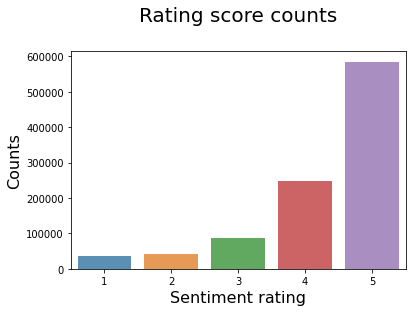

In [49]:
#1-3: Negative, 4-5: Positive
a_rating, b_rating, sorted_unique_rating = count_unique(arr[:, all_columns['rating_review']], 'ratings', 1)
sorted_unique_rating
### Bar plot for rating_review count
ax = sns.barplot(a_rating, b_rating, alpha=0.8)
plt.title('Rating score counts',fontsize=20, pad=30.0) 
plt.xlabel('Sentiment rating', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.show()

Count unique restaurants and most and least popular (reviewed) restaurant

In [ ]:
a_rest, b_rest, sorted_unique_rest = count_unique(arr[:, all_columns['restaurant_name']], 'restaurant', 1)
print(f'Most populat restaurant {sorted_unique_rest[0][1]} reviewed {sorted_unique_rest[0][1]} times.')
print(f'One of the least populat restaurant {sorted_unique_rest[-1][0]} reviewed {sorted_unique_rest[-1][1]} times.')#1827

Number of unique restaurant 1827
Most populat restaurant 7018 reviewed 7018 times.
One of the least populat restaurant Dera reviewed 1 times.


Best and worst restaurants based on rating_review

In [ ]:
pos_mean = [np.mean(arr[arr[:, all_columns['restaurant_name']]==i, all_columns['rating_review']], axis=0) for i in a_rest]
max_idx = pos_mean.index(max(pos_mean))
print(f'{sorted_unique_rest[max_idx]} restaurant has maximum average rating of {pos_mean[max_idx]}')
min_idx = pos_mean.index(min(pos_mean))
print(f'{sorted_unique_rest[min_idx]} restaurant has minimum average rating of {pos_mean[min_idx]}')

ax = sns.barplot(a_rest[:10], pos_mean[:10], alpha=0.8)
plt.title('Top 10 restaurants in London', fontsize=20, pad=30.0) 
plt.xlabel('Restaurants names', fontsize=16)
plt.ylabel('Average rating', fontsize=16)

ax = sns.barplot(a_rest[-10:], pos_mean[-10:], alpha=0.8)
plt.title('Worst 10 restaurants in London', fontsize=20, pad=30.0) 
plt.xlabel('Restaurants names', fontsize=16)
plt.ylabel('Average rating', fontsize=16)

('Dirty_Bones_Carnaby', 685) restaurant has maximum average rating of 5.0
('Hache_Shoreditch', 372) restaurant has minimum average rating of 3.2941176470588234


Number of unique reviewers

In [ ]:
a_author, b_author, sorted_unique_author = count_unique(arr[:, all_columns['author_id']], 'user', 1) #(restaurant_name:count)

Number of unique user 502227


 Number of reviews per user

Number of unique reviewers 502226


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Reviews per user')

Text(0.5, 0, 'User')

Text(0, 0.5, 'Counts')

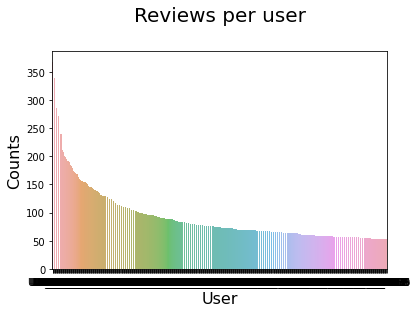

In [48]:
author_freq_count = Counter(arr[:, all_columns['author_id']]).most_common() 
print(f'Number of unique reviewers {len(author_freq_count)}')
author_freq_count = sorted(author_freq_count, key=lambda x:x[1], reverse=True)
review_freq, author_count = list(zip(*(author_freq_count)))
ax = sns.barplot(np.array(review_freq[:500]), np.array(author_count[:500]), alpha=0.8)
plt.title('Reviews per user',fontsize=20, pad=30.0) 
plt.xlabel('User', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.show()

Number of positive vs negative reviews

Number of unique sentiment 2


[('Positive', 831686), ('Negative', 164860)]

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'Rating score counts')

Text(0.5, 0, 'Sentiment rating')

Text(0, 0.5, 'Counts')

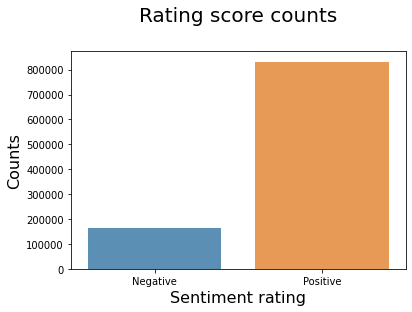

In [46]:
a_sample, b_sample, sorted_unique_sample = count_unique(arr[:, all_columns['sample']], 'sentiment', 1)
sorted_unique_sample
### Bar plot for sample count
ax = sns.barplot(a_sample, b_sample, alpha=0.8)
plt.title('Rating score counts',fontsize=20, pad=30.0) 
plt.xlabel('Sentiment rating', fontsize=16)
plt.ylabel('Counts', fontsize=16)
plt.show()

Remove nan reviews

In [ ]:
nan_review = [idx for idx, item in enumerate(arr[:, all_columns['review_full']]) if isinstance(item, float)]
print('Row index with nan reviews {}'.format(nan_review))
arr = np.delete(arr, nan_review, 0)

Row index with nan reviews [196133, 412018, 592744, 602250, 604108, 662606]


In [ ]:
for item in arr[:,2]:
    if isinstance(item, float):
      print(item)

Change type, date: str and datetime format

In [ ]:
arr[:, all_columns['date']] = arr[:, all_columns['date']].astype('str')
#arr[:, all_columns['date']][:10]
wo_nan_date = [item for item in arr[:, all_columns['date']] if item != 'nan']
print(f'Reviews collected from {min(wo_nan_date)} to {max(wo_nan_date)}')

Reviews collected from April 1, 2008 to September 9, 2020


Count unique cities

In [ ]:
unique_city = np.unique(arr[:, all_columns['city']], return_counts = True)
unique_city_all = list(zip(unique_city[0],unique_city[1]))
print('Number of unique cities {}'.format(len(unique_city_all)))
sorted_unique_city_all = sorted(unique_city_all, key=lambda t: t[1], reverse=True)
sorted_unique_city_all

Number of unique cities 1


[('London_England', 996546)]

Drop unnecessary columns

In [ ]:
drop_col = ['Index', 'parse_count', 'restaurant_name', 'sample', 'review_id', 'review_preview', 'date', 'city',  'url_restaurant','author_id'] 
col_to_delete = [all_columns[item] for item in drop_col]
arr_clean = np.delete(arr, col_to_delete, 1)

In [ ]:
merge_txt = arr_clean[:,1]+' '+arr_clean[:,2]
merge_txt[0]

'JUST PERFECT I was away for couple of months and I am so happy to be back for my regular cocotte meal, after collecting from the restaurant everything was as great and perfect than eating in. Juicy chicken, fresh side, amazing mash potato.What a great dinner at home again thanks to COCOTTE.'

Check common reviews

In [ ]:
print(len(arr_clean[:,2]) - len(set(arr_clean[:,2])))

293


Pre-process text

In [ ]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    #elif tag.startswith('N'):
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def process(sentence):
    # Remove special charaters
    output = re.findall('[\w]+', sentence.lower())
    # Remove digits
    output = [re.sub(r'\d+', '', item) for item in output]
    # Remove urls
    output = [re.sub(r'http\S+', '', item) for item in output]
    #work level tokenise
    #word_list = nltk.word_tokenize(output)
    #pos tag
    output = nltk.pos_tag(output)
    # lemmatize
    tokens = [lemmatizer.lemmatize(item[0], get_wordnet_pos(item[1])) for item in output if item[0] not in stop]
    # if using TfidfVectorizer or CountVectorizer, as they expect sentence and not tokens. They tokenise themselves.
    tokens = (' ').join(tokens)
    return tokens

In [52]:
#Initialise lemmatizer
lemmatizer = WordNetLemmatizer()
# stop words
stop = set(stopwords.words('english') + list(string.punctuation))
stop.add('')
processed_reviews = [process(sent) for sent in merge_txt[:500000]]

In [54]:
np.shape(merge_txt)

(996546,)

In [ ]:
with open('sentiment_analysis.csv', 'w', newline='') as csvfile:
    fieldnames = ['text', 'score']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for i in range(len(processed_reviews)):
      writer.writerow({'text': processed_reviews[i], 'score': arr[i, all_columns['rating_review']]})

297

674

389

267

954

137

409

439

745

164

665

1240

620

152

511

534

1063

815

867

482

161

261

840

127

233

496

622

831

113

276

366

265

185

287

835

666

686

1036

163

277

558

185

245

311

161

124

391

472

570

142

301

256

146

253

145

757

244

139

130

141

127

339

119

197

122

314

143

483

1218

423

151

275

181

1486

119

387

231

454

849

763

216

260

532

250

275

114

233

190

894

601

653

319

471

308

846

254

801

476

439

511

314

322

320

119

159

139

956

403

141

357

558

363

141

239

242

162

203

351

364

419

140

230

410

159

505

280

468

190

258

575

176

259

424

229

198

769

432

303

234

348

562

619

690

216

299

160

121

196

1579

319

208

142

402

146

235

428

349

166

232

286

167

630

164

135

124

736

1039

433

776

529

156

609

274

238

363

270

309

284

164

253

160

758

563

224

391

630

893

863

581

298

212

137

180

468

202

1003

819

198

431

642

167

383

527

182

463

312

764

187

160

182

695

430

226

363

853

230

975

1469

242

201

253

168

536

337

179

327

185

501

753

2153

270

663

340

133

195

302

331

245

2109

5533

221

539

171

424

159

512

688

1205

474

260

207

173

544

765

214

331

400

227

135

275

303

373

194

356

731

845

1535

160

194

445

298

628

375

149

180

157

471

433

204

303

456

120

148

216

118

253

267

340

721

199

186

312

498

238

406

428

328

283

218

203

556

379

224

212

149

219

186

382

317

339

235

249

257

1107

365

162

215

160

497

175

179

131

173

609

908

491

273

448

259

128

236

716

280

860

207

200

154

313

735

211

767

139

133

344

514

286

628

248

202

319

340

172

2995

227

506

150

182

596

754

854

518

192

297

145

154

133

258

482

469

328

144

170

112

387

173

125

144

368

238

249

281

527

901

679

1005

1000

787

461

202

76

805

243

137

166

718

259

112

419

488

317

132

321

151

135

924

162

170

111

259

205

1261

171

299

1622

444

953

1105

486

262

269

182

127

450

335

743

244

167

209

505

957

164

589

175

616

1429

134

1229

289

163

204

187

641

180

630

169

189

284

428

527

606

415

463

357

117

400

326

1134

209

334

140

389

167

616

456

1006

608

280

723

493

1524

715

613

649

331

188

421

316

210

2167

762

323

256

591

133

532

489

168

303

379

1352

344

1283

293

127

590

440

114

421

134

131

683

278

336

504

430

166

352

448

216

321

360

605

630

154

623

467

388

1053

757

347

135

335

219

2711

267

385

659

600

161

925

169

505

641

142

593

292

264

187

474

265

517

191

273

225

337

480

320

194

422

265

372

571

318

199

394

599

432

745

132

136

129

830

851

360

355

324

297

447

217

260

142

267

211

193

161

189

198

206

218

146

196

183

124

280

210

585

335

392

265

152

239

227

163

344

244

2165

220

298

257

795

158

306

150

131

245

128

299

200

178

413

197

160

422

419

163

449

462

1193

628

383

1125

295

217

273

225

152

164

140

338

600

1354

240

5583

524

411

358

368

487

250

265

868

596

642

401

617

201

143

306

189

351

547

398

445

611

192

712

143

627

169

467

387

392

1174

140

119

306

144

593

182

158

1337

256

1554

686

137

553

948

282

312

368

145

527

150

343

330

390

384

935

258

378

454

190

135

232

139

188

908

141

285

464

313

208

594

181

432

398

358

859

216

160

356

237

222

314

319

1193

288

369

447

418

159

281

604

233

135

441

205

541

222

207

298

131

411

240

158

402

174

937

304

142

1231

230

239

140

514

127

223

179

243

900

138

473

591

220

184

503

662

633

301

237

345

161

263

509

138

441

735

2053

431

431

526

350

394

185

637

514

422

246

345

496

222

185

235

389

779

157

418

201

143

340

262

1018

448

605

433

228

204

144

143

217

3978

383

252

1133

343

186

507

419

633

382

424

349

426

216

426

584

874

347

161

374

136

380

464

170

1047

409

978

1541

485

266

259

341

324

510

131

415

1083

967

842

1318

326

482

537

460

1186

211

216

308

233

175

315

198

304

405

185

269

789

358

411

125

456

640

685

476

908

505

595

186

651

1085

553

537

160

215

120

133

159

165

120

252

291

170

922

610

150

371

241

315

504

404

203

817

162

163

258

656

1740

498

654

621

689

250

358

167

199

271

231

190

144

428

520

180

150

233

281

185

334

178

3035

107

138

687

1022

902

568

678

346

359

124

194

176

125

1639

619

211

298

178

488

500

171

142

221

151

298

197

260

353

327

288

335

246

811

194

1386

230

147

434

253

215

309

304

404

335

903

264

854

608

190

627

1036

260

348

212

337

260

137

153

154

295

627

505

266

338

263

365

236

513

524

730

199

132

830

170

161

206

169

203

290

257

194

416

320

334

152

161

139

312

677

1102

280

607

289

497

249

302

232

252

253

134

389

467

175

117

135

310

154

732

376

200

151

355

436

331

213

204

382

273

692

499

175

425

220

443

338

212

276

414

152

120

207

146

244

154

396

159

173

276

829

132

1003

213

148

132

126

319

150

140

142

127

195

148

654

171

173

147

231

244

147

420

428

199

222

842

178

114

132

145

315

163

688

219

341

163

290

326

202

144

804

471

229

305

278

226

447

1685

1219

131

126

307

391

322

756

156

289

251

1435

227

310

144

199

195

219

379

565

288

165

335

159

186

125

215

241

240

269

127

339

369

457

419

447

459

1459

352

430

885

1739

309

782

143

349

433

418

244

194

479

223

146

221

115

171

221

361

217

237

193

268

232

222

313

1498

173

139

132

233

287

205

475

286

542

643

143

279

171

317

289

427

144

316

256

114

128

744

570

401

287

939

176

172

474

147

381

242

618

217

643

489

152

863

722

331

1226

619

328

576

214

227

168

265

518

186

734

503

376

542

411

230

398

1275

1422

510

285

1375

720

758

448

157

185

183

354

524

467

155

758

320

353

139

504

443

414

209

746

621

285

1472

329

262

157

435

2801

275

2773

127

431

675

281

150

116

1008

475

147

836

1400

213

512

489

282

405

1019

122

260

475

607

277

325

343

227

295

365

621

532

136

967

442

580

138

1380

2238

259

615

273

434

803

271

477

445

485

835

591

846

1503

665

474

189

170

783

239

796

705

435

1484

537

175

441

452

311

326

463

504

726

263

190

365

343

365

247

421

431

363

234

261

158

456

364

344

140

714

458

1200

158

246

228

359

165

228

992

147

132

124

360

185

771

274

279

165

130

386

699

149

143

311

298

366

144

302

1714

280

290

192

137

161

765

332

405

131

635

170

146

147

227

261

243

321

765

237

138

994

438

116

2937

286

320

243

676

130

404

634

377

807

255

228

152

227

541

126

384

374

289

287

308

278

222

343

179

253

300

195

915

142

496

673

274

307

203

384

550

237

178

347

179

167

310

594

352

548

196

267

2740

557

175

590

175

300

346

196

257

141

178

431

121

385

254

274

682

1734

685

236

198

933

458

217

515

611

352

1452

117

592

312

160

279

177

466

352

169

410

197

365

159

343

252

198

337

1102

1618

146

445

447

309

255

184

397

370

347

1634

904

710

455

1271

277

168

299

222

229

230

170

176

1054

540

243

122

452

154

415

1308

182

139

1262

341

432

284

171

239

803

1420

876

749

162

290

371

277

1117

420

786

115

139

319

405

209

1083

982

1236

386

343

961

414

326

1575

271

345

225

343

555

278

1365

135

141

191

1506

174

524

409

363

713

1356

508

371

691

397

517

202

270

294

409

187

484

367

238

192

139

162

438

374

599

203

355

737

1193

277

326

227

204

136

226

176

307

676

469

447

186

511

1164

2061

683

460

432

302

281

414

221

153

339

635

689

948

513

347

787

519

576

168

719

401

218

300

323

1472

349

416

534

681

288

383

582

1125

158

1180

179

151

149

227

232

530

490

436

318

153

214

508

307

432

374

155

301

1011

344

500

271

401

169

342

329

226

824

360

316

178

319

649

367

151

230

232

135

147

1210

475

749

449

364

952

242

547

192

719

251

118

196

143

365

176

841

444

196

300

422

174

139

333

613

260

273

1238

485

366

634

686

547

1767

238

322

376

211

696

1104

309

292

1140

618

1971

349

526

375

690

179

220

1146

595

251

892

501

251

384

441

332

360

719

398

257

292

384

310

1486

515

175

854

296

667

469

548

221

404

419

148

384

576

247

220

366

1141

152

199

141

414

286

475

645

429

258

541

219

791

1455

628

290

310

335

175

276

589

402

780

308

156

467

160

9349

134

457

611

266

204

309

655

1265

257

288

619

501

207

342

475

211

295

124

780

141

164

426

756

176

178

505

453

191

380

154

470

178

499

1035

337

302

161

141

536

243

253

126

331

342

855

182

568

322

230

500

180

289

291

280

143

433

1079

236

441

465

309

297

143

238

408

310

309

281

202

400

522

228

125

316

753

427

345

204

688

280

134

614

804

182

890

632

1553

451

213

446

135

209

155

285

313

356

541

141

116

193

302

269

301

255

376

356

160

444

117

526

493

144

244

211

133

503

954

400

220

1037

387

858

244

359

1028

606

796

330

314

308

769

137

529

483

576

270

798

1440

1937

1358

1009

473

269

483

883

216

315

142

167

779

328

467

244

188

270

223

290

1148

196

283

215

649

325

201

144

595

215

210

307

146

428

151

183

267

398

175

645

982

1121

595

490

360

368

325

357

572

751

157

331

130

886

2782

1206

762

191

338

188

152

709

540

228

809

960

130

532

376

128

548

450

604

492

836

613

1857

401

138

150

142

130

589

1420

685

782

490

494

1297

451

851

239

205

264

327

140

329

339

633

135

180

126

156

378

467

417

792

294

226

645

296

3865

711

1458

608

2611

974

487

299

456

137

212

1046

333

516

643

709

368

157

253

904

486

910

817

253

780

810

286

241

189

1366

592

784

832

412

152

142

265

304

498

206

278

268

399

312

131

392

774

315

318

650

551

336

144

522

688

326

125

252

1630

271

304

763

389

1648

150

359

902

478

144

185

549

211

402

427

119

1222

421

190

567

526

285

234

296

166

151

216

744

375

304

150

624

315

429

237

381

285

248

137

229

254

279

644

170

190

152

240

409

274

414

492

184

368

1782

210

165

188

381

1263

300

742

293

594

127

402

1235

355

195

344

191

270

347

482

156

437

322

585

634

322

117

403

247

140

149

123

309

452

175

257

140

181

484

575

232

207

249

628

2864

419

177

177

175

669

237

134

189

112

743

130

999

475

558

346

611

314

1930

121

272

145

424

744

241

723

482

1324

213

732

279

410

493

379

136

170

364

381

568

452

251

339

335

537

303

786

470

659

496

160

139

640

556

194

334

182

883

494

304

247

674

365

668

479

706

243

266

372

798

576

286

376

856

310

1139

551

431

215

317

777

388

262

723

820

945

194

533

605

619

515

266

145

453

176

135

132

661

942

701

521

656

547

177

290

191

664

474

222

485

453

148

182

260

331

3639

188

262

693

720

1071

456

620

517

928

748

386

1422

406

615

144

141

1408

146

189

147

387

303

906

650

616

574

407

342

398

241

1894

198

155

248

453

377

285

959

969

218

311

168

207

197

130

169

182

246

367

220

965

233

492

213

339

178

406

226

382

374

560

121

195

360

144

365

407

404

322

309

523

333

309

121

276

152

191

180

1546

596

262

137

776

812

293

254

855

694

623

203

204

305

440

750

949

122

373

1076

854

150

400

187

263

426

295

278

149

390

130

638

833

864

566

1020

1958

190

191

390

268

608

790

335

121

377

390

449

533

263

208

1397

375

361

473

382

183

397

362

420

268

405

566

511

810

1123

468

320

333

409

825

488

338

559

604

309

453

579

311

323

562

312

260

366

360

144

291

192

155

167

485

142

833

356

3555

1032

358

398

259

1555

543

164

243

1401

510

830

248

514

406

455

221

622

417

223

564

533

342

349

671

510

133

700

409

693

196

123

395

423

385

270

145

281

198

263

301

321

448

574

157

289

884

794

285

302

209

1306

228

232

864

620

203

1835

470

4104

812

499

155

214

1846

669

1012

388

871

755

732

326

788

289

641

819

540

164

437

1326

200

355

411

566

270

203

249

306

263

320

312

265

302

256

187

203

401

825

325

298

223

316

259

296

306

266

742

184

1580

306

238

176

370

514

545

125

222

240

185

668

344

10173

228

939

462

277

965

250

1413

444

221

778

261

286

377

475

621

167

226

210

934

304

421

221

1309

889

377

342

582

879

169

503

145

200

556

1257

382

807

319

420

796

631

361

638

417

208

608

467

835

163

454

378

187

266

204

1069

277

442

780

834

440

292

545

181

120

204

239

566

215

179

1544

529

227

2436

517

261

587

479

243

476

285

865

625

182

165

124

528

275

148

287

349

402

1203

570

407

800

282

241

453

949

723

126

850

413

133

293

331

844

1088

427

543

252

1391

499

1785

268

625

633

307

277

522

657

337

311

1140

831

159

747

551

241

685

241

174

143

769

291

672

379

153

189

199

568

312

301

228

219

1698

1022

155

164

885

467

259

448

237

149

326

305

179

192

936

210

204

113

330

941

506

918

316

379

825

122

248

173

529

639

492

921

179

921

542

145

232

633

245

1401

1406

552

1630

331

674

177

443

296

1582

371

458

378

231

482

138

213

126

527

325

237

162

728

319

300

1044

135

197

145

144

291

586

506

376

396

1022

313

1116

222

627

700

294

123

257

486

274

415

268

514

358

358

796

1042

583

242

621

176

1007

823

441

148

197

174

274

280

314

212

245

225

700

350

196

206

887

176

1091

436

312

264

137

140

990

1186

154

414

141

877

381

137

255

151

138

133

139

529

182

150

247

385

141

228

161

687

323

202

168

475

400

300

114

145

250

194

197

182

250

241

112

150

204

701

287

149

1315

321

279

1225

308

192

293

143

373

461

386

155

251

120

133

286

813

337

221

755

169

387

968

264

773

419

220

511

374

155

451

354

960

418

527

306

222

166

293

225

186

482

673

522

142

351

773

371

152

402

276

372

213

173

143

134

164

323

543

449

116

315

411

540

157

1569

493

1294

1008

811

845

253

1607

377

169

442

145

352

423

353

509

166

1112

351

143

378

390

1075

778

729

359

147

151

429

273

161

149

397

688

1385

243

366

162

595

126

251

227

504

350

983

671

413

1875

232

408

630

584

351

498

847

623

665

250

194

185

273

137

425

257

385

265

187

786

172

555

726

959

471

411

326

216

569

124

167

328

218

238

265

244

204

275

301

149

209

159

520

488

565

164

253

562

326

192

259

132

119

139

180

672

1599

356

711

277

604

139

313

211

185

358

261

230

161

128

320

152

238

168

281

737

1090

986

515

999

285

872

166

150

182

1455

295

911

1244

1021

590

1004

626

477

576

703

337

219

948

940

1110

220

417

831

413

155

495

189

975

230

2208

534

258

223

797

1367

179

186

1255

463

2031

340

152

1090

297

182

771

325

194

241

285

151

123

121

540

119

132

252

354

666

211

526

512

1415

236

468

143

217

217

126

181

448

621

364

1036

340

233

572

443

164

528

560

647

155

546

154

182

565

1628

577

723

286

599

754

209

112

166

433

307

336

545

294

314

153

203

233

210

170

209

223

183

189

374

207

352

338

352

225

209

214

291

176

247

162

313

281

884

133

224

163

383

303

234

746

417

364

748

608

981

2542

440

244

258

298

148

1013

229

319

359

260

496

143

926

206

603

140

280

120

141

853

145

359

1130

296

418

319

150

136

520

438

484

149

1024

653

432

701

397

269

360

140

563

701

447

404

232

364

548

563

1277

279

348

162

440

398

384

238

819

487

481

470

346

192

330

210

488

124

179

250

357

1929

154

154

674

173

225

624

176

121

385

1171

499

120

512

647

627

172

405

226

134

140

337

380

163

280

236

238

357

542

275

463

363

295

1905

962

1112

1281

298

472

198

652

1210

185

237

243

283

400

912

251

533

390

174

466

1339

451

436

410

967

504

380

250

126

408

893

925

516

187

240

245

177

210

126

132

175

134

228

117

136

137

140

127

240

216

496

329

145

374

189

150

122

377

117

132

451

231

293

227

318

164

317

301

167

251

267

202

748

151

483

795

1204

240

266

539

175

1223

158

184

149

604

941

397

877

938

176

716

235

317

1048

345

335

162

199

218

125

136

188

345

812

446

218

341

186

331

138

125

248

267

542

275

231

750

149

145

226

414

148

178

415

128

277

185

149

668

136

164

530

231

363

142

1137

416

129

171

226

383

295

298

232

184

388

156

572

765

262

383

706

166

129

151

557

230

402

631

312

220

145

366

120

143

151

919

582

177

237

663

1152

1563

1363

529

520

179

243

615

120

136

364

332

490

112

145

390

267

324

199

592

304

514

189

877

1466

579

593

322

111

168

151

302

386

886

169

536

422

225

191

225

419

734

1691

581

1751

1144

245

721

789

329

187

369

155

213

463

288

370

316

193

223

388

122

285

258

392

363

288

522

420

592

137

331

269

108

141

183

214

231

156

182

153

154

709

672

151

243

446

168

140

305

587

291

683

694

271

189

174

220

151

175

155

144

140

441

165

131

130

379

578

287

310

128

153

124

149

119

307

753

913

184

561

247

391

304

337

206

3154

521

291

662

1489

550

1004

264

231

1868

230

825

592

747

611

441

429

220

312

487

151

551

156

167

217

132

260

358

226

274

738

259

162

209

115

183

295

315

704

202

822

385

417

613

146

267

951

810

242

122

206

688

208

358

188

153

715

1817

444

138

179

196

639

581

555

254

389

127

194

839

481

394

1047

512

161

125

390

311

425

654

552

436

549

344

564

476

165

394

270

244

191

414

236

504

124

239

269

510

133

856

421

626

316

495

325

155

771

427

524

221

144

275

188

300

386

423

194

344

686

569

406

359

1206

435

370

159

249

1263

448

587

404

283

413

166

283

163

153

822

145

130

231

631

2299

903

403

1260

236

1423

284

171

228

120

208

559

625

188

862

304

387

268

252

370

541

154

400

148

1053

192

229

241

208

139

798

308

115

798

124

167

322

561

287

243

161

408

517

254

1110

593

1035

423

1343

786

357

512

338

745

680

1443

2368

604

366

132

127

278

163

238

3515

1795

424

863

1181

1346

1101

819

365

138

572

315

350

294

382

314

697

449

132

571

156

128

140

131

303

148

137

138

325

236

309

187

227

198

1150

655

160

456

250

420

1054

735

361

1029

863

1111

1103

607

159

546

233

857

525

991

317

779

162

197

233

135

239

250

272

697

166

251

581

438

165

533

133

312

154

801

167

937

174

211

129

877

321

377

212

480

224

319

171

395

287

330

991

178

828

1063

324

199

291

272

373

504

306

410

322

835

1222

684

897

153

458

297

335

234

363

158

340

138

510

207

350

126

292

239

306

327

1019

1488

604

434

659

343

412

353

808

126

325

142

135

1119

289

800

154

508

405

936

196

749

924

236

191

497

163

134

115

510

537

163

132

560

283

637

127

437

117

413

209

493

346

219

1251

618

203

730

324

377

635

455

413

347

331

132

579

448

722

225

229

287

1684

252

623

430

712

311

477

989

460

552

307

799

1002

341

164

356

852

329

226

595

340

380

791

440

336

160

897

190

754

158

461

498

1256

486

1192

694

801

613

208

415

140

764

808

290

986

468

1141

387

1178

166

313

265

795

278

237

174

581

490

299

244

142

154

316

343

252

477

877

195

256

200

313

399

270

162

113

353

758

119

411

381

1576

293

201

520

167

131

210

148

751

829

936

308

268

142

207

340

453

597

619

460

875

174

1155

544

270

211

263

146

204

173

386

177

292

132

197

197

556

138

767

3428

289

1268

240

246

237

142

114

162

273

344

273

372

554

225

304

139

202

403

164

125

1344

1792

295

486

222

129

450

237

159

458

621

265

971

264

205

139

147

831

515

277

1708

424

395

146

187

378

300

682

322

131

334

706

1152

419

556

146

834

153

682

728

331

367

992

392

367

524

215

341

369

906

388

2484

207

128

152

193

333

215

369

255

521

125

792

341

261

702

464

474

255

301

360

869

429

211

475

194

368

445

227

168

445

849

907

558

129

801

642

435

522

267

515

305

248

118

159

750

278

451

2230

646

329

475

978

633

327

276

247

138

602

351

144

451

253

718

837

1129

246

431

575

450

1626

354

125

184

560

141

529

303

199

179

1206

444

204

893

312

751

552

378

543

624

484

1020

161

194

402

486

780

281

733

335

455

116

159

1032

226

427

811

847

172

148

289

327

931

199

177

264

227

369

554

686

120

384

662

219

505

637

286

297

1159

720

325

300

1108

1020

280

882

199

205

409

444

595

290

738

1961

1102

1205

207

305

203

376

1122

700

493

1651

159

236

207

176

124

116

148

173

375

403

502

370

855

1637

351

533

805

293

133

163

649

1112

256

536

241

1087

521

461

544

145

520

683

236

579

302

488

298

226

138

216

321

370

144

177

297

193

387

251

659

582

416

710

846

563

245

177

131

225

1111

2840

1122

120

162

1494

265

1886

310

701

805

281

387

672

492

1144

755

231

172

170

558

993

280

613

537

439

384

790

693

328

285

235

132

198

192

145

269

477

383

286

304

225

251

418

429

189

225

1467

485

837

175

1521

553

456

512

336

1901

504

1880

459

420

315

136

553

133

123

475

227

937

314

638

215

914

165

565

349

311

251

194

576

317

654

223

303

448

698

471

153

327

146

355

679

113

135

320

250

603

261

366

223

166

150

814

620

1183

631

128

400

170

325

421

549

583

899

215

150

176

1032

741

202

189

173

367

536

2315

368

300

116

136

339

224

446

981

256

571

430

1185

139

470

130

1420

743

444

638

723

290

295

254

155

532

1145

131

174

717

608

538

549

435

248

143

320

307

1115

254

339

144

147

657

227

405

1799

254

883

413

332

785

371

127

173

447

124

156

156

418

175

464

255

224

168

309

209

801

383

959

1131

866

347

354

164

429

953

1089

220

539

220

1401

640

194

166

494

589

1620

1159

857

114

221

149

172

260

487

152

245

443

148

222

132

167

269

868

899

577

1076

582

571

247

171

676

198

132

125

716

594

314

778

276

422

516

355

532

956

587

305

335

597

685

368

229

148

320

962

547

365

243

889

404

478

1092

326

692

170

403

187

180

279

371

929

342

1316

453

197

262

249

317

453

317

981

639

128

482

415

566

283

464

428

851

503

209

801

323

251

397

356

194

269

583

363

777

340

5103

856

721

680

547

1050

174

148

601

1375

397

542

456

133

185

4712

301

593

138

151

416

253

526

900

1458

1021

826

1805

680

704

219

2668

227

649

759

854

501

244

123

143

481

429

489

464

206

199

1237

638

1416

713

451

932

829

132

650

851

392

182

404

863

378

433

462

548

458

393

2316

643

548

868

498

526

410

652

548

162

816

339

1118

685

223

366

382

151

283

586

193

1028

289

493

238

1000

231

586

821

357

330

326

637

333

1073

324

215

196

428

165

169

295

346

409

288

1796

479

219

221

255

380

700

307

307

391

489

246

282

451

875

1319

426

179

405

292

514

916

508

261

499

511

315

260

274

445

247

387

326

562

176

302

180

566

1217

199

402

198

378

131

425

573

319

476

601

145

3410

541

542

1023

814

448

1262

182

205

592

169

317

388

1198

330

1289

1128

283

131

1116

316

240

557

548

186

200

830

651

247

1166

467

920

841

3939

2003

359

596

844

438

1968

559

309

227

641

353

629

134

235

308

346

538

1558

539

578

937

399

228

605

544

221

150

2671

387

448

142

533

362

537

1030

458

299

641

296

433

339

270

825

520

635

728

848

505

359

222

246

525

716

376

269

268

484

501

188

578

258

919

380

1189

485

376

493

1349

757

279

1011

438

450

534

330

195

754

219

441

417

239

442

583

742

530

234

478

1149

187

198

345

386

949

416

735

472

1404

800

332

246

466

855

394

1018

391

343

444

414

139

327

156

262

161

433

344

348

304

402

816

500

1555

1506

1556

447

587

428

292

643

585

353

164

359

297

327

505

373

852

1318

157

329

175

415

845

1345

776

822

519

266

150

371

233

436

280

585

615

1271

457

269

191

212

615

149

447

420

463

621

356

350

380

137

388

883

760

275

165

653

445

583

190

510

152

504

141

408

139

1296

1136

309

658

364

182

653

654

934

240

709

348

198

217

323

482

549

367

452

409

278

350

432

205

515

538

1096

415

220

352

502

307

147

188

155

220

565

594

859

500

1270

461

3097

816

146

653

379

214

262

174

330

288

428

138

378

806

543

201

498

275

467

888

626

294

334

748

1512

328

181

301

3078

627

137

616

160

358

397

461

244

2745

395

462

144

291

248

461

214

343

416

1432

514

638

477

773

899

602

188

239

180

239

625

253

520

503

160

388

999

690

170

616

696

1151

412

607

557

249

531

803

285

643

490

738

584

809

528

212

341

157

202

322

649

375

309

986

829

7179

152

273

220

690

748

598

760

1283

368

906

193

334

440

1240

1038

231

607

178

420

550

747

507

786

227

413

344

784

337

1621

360

380

715

502

648

550

1270

556

228

224

338

471

211

365

177

505

492

534

251

314

759

2192

216

282

433

220

280

425

361

190

316

506

546

349

234

334

174

255

1385

1709

743

427

1071

614

450

452

586

407

298

1399

1498

775

655

1344

217

566

441

557

838

1175

610

1104

283

376

624

1705

645

152

557

718

890

340

1596

239

584

521

607

428

332

205

652

2226

544

585

993

281

120

1147

174

791

459

1125

208

514

393

437

824

215

355

332

271

159

149

246

195

257

708

875

713

599

325

156

376

280

727

632

962

956

218

576

694

121

1500

341

255

449

160

364

143

144

794

822

919

701

1027

242

855

726

226

397

142

581

302

147

250

692

1251

426

373

808

2143

233

483

1309

141

311

142

574

495

377

1196

738

506

457

665

499

250

356

292

127

155

261

1555

430

430

238

1248

155

266

1021

1304

772

468

500

436

171

775

502

336

759

2178

468

1054

590

345

200

816

336

511

221

365

391

357

465

1154

238

159

234

306

258

409

467

350

671

726

290

711

604

514

263

176

1130

300

673

266

658

840

361

229

631

176

175

355

732

223

401

299

122

839

146

386

1385

204

894

451

495

372

285

496

417

216

1070

764

220

340

187

185

511

120

794

194

268

201

552

822

246

419

593

300

262

249

293

144

113

154

541

390

431

236

577

262

305

136

510

214

451

375

267

751

571

229

443

539

1387

488

459

700

501

503

199

827

287

407

224

789

385

152

508

615

611

238

474

876

340

262

515

210

590

1019

454

546

154

197

236

150

119

844

221

549

1373

162

590

798

508

472

372

430

1592

132

582

1055

310

436

717

1000

1781

1564

637

583

577

408

439

584

450

311

694

589

332

390

515

633

662

338

707

352

336

2354

341

764

572

285

385

360

1594

684

526

950

684

714

236

514

544

354

263

502

112

495

638

139

270

159

1138

2109

693

511

289

217

380

183

462

869

141

194

983

543

1964

966

1731

606

619

1165

691

1091

647

640

286

1149

267

213

1113

903

624

1901

610

955

301

358

567

261

656

272

591

396

128

130

673

374

607

284

1010

247

160

161

927

525

414

759

850

229

371

144

160

239

284

930

254

240

206

195

138

418

235

316

175

164

1525

356

131

139

112

352

430

194

239

262

1509

215

393

135

667

802

459

485

318

490

301

1468

373

888

329

810

847

330

440

932

513

798

190

1008

211

582

213

532

327

364

611

388

185

173

127

116

218

764

448

123

886

354

200

223

181

430

153

607

745

805

646

876

664

1777

219

800

420

414

792

387

354

558

632

1238

447

367

298

740

174

158

288

138

558

121

130

363

498

1276

351

153

490

254

439

7970

826

692

193

403

364

142

579

1140

1488

738

183

215

779

157

619

601

383

381

233

437

297

431

497

420

118

244

600

343

459

629

459

276

677

111

679

550

553

240

182

204

843

452

133

186

227

1007

196

458

1273

440

1227

977

214

1550

132

2043

257

239

228

263

1265

1855

639

475

909

311

789

245

463

371

261

134

873

239

540

1257

707

562

337

257

554

641

731

152

755

1156

393

258

308

167

184

484

460

187

619

193

277

121

341

391

677

534

2087

942

624

326

156

1743

943

181

445

156

232

438

186

1378

608

697

146

2345

727

1703

538

588

789

493

214

247

703

434

143

147

1132

445

497

151

225

161

400

217

638

185

115

3420

370

1083

2170

543

402

449

389

742

1144

439

272

415

821

771

117

226

212

214

444

135

299

386

388

303

433

902

670

2862

2263

673

464

169

925

239

144

369

299

176

899

979

393

394

297

246

1825

430

548

148

208

805

433

455

163

354

620

944

424

2910

447

507

632

1025

380

331

828

692

442

524

703

151

330

230

338

118

485

124

489

559

288

165

508

164

126

149

186

139

227

154

120

275

566

264

175

1136

677

531

808

675

349

554

258

777

301

136

1049

137

135

1246

377

140

472

119

153

534

286

470

315

575

565

271

490

568

283

343

315

421

909

184

557

332

226

648

1011

302

640

647

311

364

536

515

545

403

135

611

823

308

163

237

166

267

265

822

1977

253

183

705

307

632

301

330

758

2220

961

1386

1322

176

244

368

379

197

370

276

290

429

694

938

187

215

677

135

481

417

273

528

219

878

782

657

123

1579

142

1053

316

177

166

1329

295

849

372

847

543

709

347

258

617

412

959

555

193

472

116

208

375

508

287

717

563

499

276

698

468

424

2402

362

247

1252

403

251

407

447

853

159

366

208

236

347

358

361

345

301

135

1082

1080

798

613

386

317

213

133

190

201

180

126

378

518

776

525

1026

1257

442

950

310

180

153

1499

319

355

279

310

309

168

202

702

368

197

152

473

373

717

337

407

210

159

205

159

894

462

306

302

733

452

195

376

176

118

964

418

1227

480

166

145

120

152

492

373

231

473

904

714

536

558

398

234

573

189

174

278

1223

873

705

2995

2126

339

447

139

307

1457

627

389

649

676

634

785

241

467

155

1089

169

807

527

614

163

307

991

674

696

671

168

133

134

266

618

116

235

337

155

143

214

1427

341

2507

273

180

606

578

2593

543

230

165

434

171

694

193

587

852

359

242

1499

513

308

182

261

498

249

190

407

1550

276

378

379

363

337

113

395

275

218

186

178

1328

280

1042

1083

175

148

362

309

157

658

145

180

243

388

202

224

598

1272

454

351

266

214

333

156

694

359

162

227

1214

284

376

306

275

274

147

258

1158

3038

659

294

305

341

559

154

255

148

493

215

201

686

1241

957

195

1002

408

223

177

399

334

172

261

309

203

313

187

243

354

194

164

282

395

182

278

228

1208

4177

272

279

493

496

287

197

273

423

588

160

294

292

337

205

259

152

543

386

459

243

136

261

297

766

496

153

752

640

525

124

276

660

467

1356

302

175

1289

222

182

217

169

207

278

200

377

201

141

1839

741

781

1152

1682

251

310

131

385

923

122

171

296

230

525

193

722

570

626

2130

460

1374

558

164

537

598

161

335

566

282

289

547

460

181

971

1383

253

150

286

657

463

448

502

485

168

460

158

246

458

295

413

508

137

126

170

361

385

1055

201

362

297

2755

590

329

305

1417

122

570

787

542

185

305

125

369

351

771

310

382

785

315

164

192

548

419

587

711

1384

369

774

688

562

213

780

144

940

569

984

1298

715

245

603

687

476

647

919

1402

595

186

135

146

120

489

1735

216

303

446

422

730

1441

720

406

304

406

378

262

135

333

198

376

298

148

557

551

346

4198

1034

122

163

562

323

139

255

205

262

145

210

223

358

116

173

168

343

346

168

254

324

252

67

461

145

295

280

422

220

117

825

269

729

545

564

838

811

736

221

1380

650

442

984

205

232

1411

521

404

264

142

200

262

771

151

220

346

540

529

236

186

333

175

131

289

165

135

385

124

173

138

288

136

191

695

364

615

789

882

792

863

538

170

143

206

650

129

120

519

150

139

357

250

404

419

167

122

459

615

183

262

216

120

165

298

124

1102

363

340

743

182

207

338

167

354

249

292

173

134

221

157

141

279

204

333

132

380

433

216

554

234

473

539

427

200

357

283

139

165

171

147

396

118

131

932

293

435

416

1056

393

240

521

1236

133

442

191

216

148

140

156

279

136

263

271

393

1038

129

130

2121

641

737

161

1373

154

113

136

257

286

290

317

123

822

281

732

494

380

253

893

178

151

348

129

181

123

396

237

236

429

1319

523

284

152

697

245

320

505

262

122

522

155

1106

223

232

707

170

437

183

182

166

166

1115

1667

344

116

1968

384

146

139

225

141

284

156

471

319

1190

171

424

195

1334

818

1405

1131

274

207

131

626

954

492

154

235

188

424

370

161

404

747

317

134

334

1251

410

238

155

679

775

307

221

258

153

613

426

151

171

453

475

171

1160

249

171

436

157

248

1014

190

274

444

114

119

138

288

335

920

620

139

90

432

517

981

1486

773

639

152

1098

368

432

494

387

260

385

541

530

173

823

647

187

515

283

295

313

171

128

248

165

213

865

167

204

305

756

444

641

823

169

428

258

855

280

379

341

206

249

421

559

245

333

322

167

1022

368

397

1192

1268

476

3296

563

188

246

394

460

486

265

661

372

166

1140

271

618

171

154

155

229

274

327

711

340

205

195

1379

202

395

330

861

165

361

969

212

386

265

164

394

121

138

569

317

332

375

676

210

1356

403

473

712

752

402

288

992

275

188

274

443

210

579

331

271

468

580

331

152

169

164

212

388

477

128

127

133

150

717

262

690

602

814

335

161

413

191

256

559

257

157

1037

256

1955

1824

389

154

248

766

147

447

276

260

310

310

749

150

1326

2211

717

260

201

1118

529

411

532

895

204

913

503

283

282

575

480

167

161

139

648

460

580

160

315

167

290

312

151

504

718

1124

835

940

729

116

397

138

159

133

285

122

1086

368

136

158

137

1360

280

702

614

308

560

821

212

357

862

133

247

142

202

138

583

502

376

756

114

124

146

126

157

158

235

10948

273

163

445

691

346

2133

297

209

384

176

777

1187

819

419

745

1074

911

1032

586

653

770

168

479

909

1402

137

134

134

221

353

125

2202

169

1463

885

665

1097

327

144

285

280

567

183

159

137

231

577

155

142

614

359

207

446

220

176

141

244

151

305

315

460

328

207

3105

955

282

463

1099

257

190

119

234

130

358

713

160

354

217

390

877

289

313

178

429

341

609

621

683

150

366

180

423

152

1892

232

212

399

120

147

170

155

180

129

179

251

116

138

468

131

167

484

307

286

302

357

418

360

381

1018

484

222

709

154

329

165

545

163

367

497

167

310

316

408

187

193

409

990

355

1304

418

317

142

678

170

666

944

402

245

434

344

517

115

452

234

565

301

745

534

276

542

461

505

390

816

392

332

260

140

464

214

560

508

329

168

116

745

161

321

270

525

544

446

922

151

760

138

452

174

251

261

661

199

501

473

529

362

515

596

220

491

678

154

576

928

234

259

489

469

156

476

677

319

648

179

235

453

899

440

312

455

477

597

562

448

464

920

1114

328

361

241

225

1531

1287

810

180

266

349

420

183

533

553

830

376

238

255

753

302

556

472

191

155

293

137

238

235

587

673

261

2095

303

590

421

1073

638

597

483

381

284

168

250

248

297

262

231

236

2576

331

300

141

678

242

246

535

384

419

832

229

276

504

197

324

589

295

158

313

322

380

130

150

347

362

746

618

1110

2030

264

272

116

270

280

233

370

204

574

448

233

546

638

164

163

134

120

193

683

412

161

733

256

144

332

161

296

134

343

382

240

668

267

387

124

294

613

360

633

128

326

2664

331

222

1358

874

470

776

458

424

317

378

513

436

147

299

403

170

233

155

167

220

171

346

687

468

505

240

171

389

490

351

143

293

1126

129

258

164

1232

718

1217

200

349

118

219

1175

927

384

903

170

123

152

144

146

479

160

151

161

187

181

138

645

1593

633

178

1369

272

139

380

137

577

160

535

828

1285

700

414

394

155

168

177

128

399

587

355

146

181

204

159

143

251

134

123

310

186

184

338

3479

437

315

247

344

328

196

402

835

212

261

323

485

382

316

245

399

228

229

347

1223

154

482

565

450

233

497

113

431

148

192

151

194

131

417

818

626

667

121

415

214

150

214

267

148

360

1214

164

393

257

306

166

1156

392

804

429

852

1806

308

124

691

284

349

143

140

254

523

785

511

532

854

1440

145

3465

835

660

259

270

285

180

249

257

585

560

1247

792

1193

266

574

407

320

711

450

234

650

887

358

378

518

181

303

389

155

399

279

151

559

328

241

1005

135

462

1503

348

382

614

165

198

460

296

262

279

124

500

460

317

473

630

260

935

2168

684

702

185

334

390

160

196

244

373

295

294

571

341

265

420

244

546

167

151

139

143

303

248

284

411

174

472

615

713

528

414

1124

710

184

557

424

636

246

254

442

405

661

127

164

218

363

590

334

419

1056

119

449

138

329

444

224

218

235

198

559

293

905

536

269

544

206

197

461

199

312

201

328

938

1046

895

336

214

166

152

1418

143

184

393

959

676

229

494

299

853

551

523

204

274

803

465

268

119

148

668

174

125

151

122

127

374

588

114

317

1020

663

170

163

559

421

415

132

1171

483

1539

195

152

141

290

123

187

128

192

239

1525

3072

467

182

769

151

160

627

279

180

299

240

1616

460

1160

566

279

408

671

1327

322

168

1101

1184

356

642

551

542

1327

492

437

473

165

162

177

128

227

379

693

455

290

169

195

170

388

9012

840

135

214

926

257

330

130

2046

725

1166

477

713

147

186

123

479

2896

672

388

120

118

149

428

876

905

702

239

724

1071

430

146

136

523

595

2230

1684

148

446

1058

279

688

230

320

139

324

146

214

916

142

292

193

141

132

275

196

916

1635

551

993

167

772

142

152

118

232

156

500

1146

135

293

166

141

169

209

138

245

188

280

441

170

132

123

135

264

160

143

128

201

221

437

573

118

340

438

304

2093

252

252

146

410

248

243

125

1679

214

632

167

1628

495

177

1047

422

615

2957

140

768

199

381

323

1548

162

3264

227

363

580

114

992

134

609

156

820

180

646

150

527

171

127

212

468

1371

127

939

119

432

296

243

222

193

389

2545

182

193

251

435

146

451

802

181

155

158

428

423

163

313

268

556

2779

829

1072

146

357

443

428

192

361

424

1073

589

217

183

158

829

439

364

384

221

445

772

815

1349

144

140

175

381

387

130

183

495

194

204

748

441

148

139

183

235

404

598

316

973

534

480

777

201

201

218

505

260

219

599

820

1620

626

497

203

571

301

124

559

232

222

286

291

331

379

900

1372

179

186

405

174

1406

186

457

128

114

175

170

830

2386

919

327

311

306

500

391

169

525

161

185

324

213

1479

122

208

1007

134

151

134

1042

132

290

1116

617

1952

235

529

425

783

352

1242

385

335

206

292

152

1688

1757

220

176

264

224

1357

622

378

152

461

392

613

260

113

124

772

391

115

792

471

4364

896

222

244

110

129

417

224

246

214

181

152

179

153

578

205

2136

806

167

207

281

524

346

135

657

271

1851

291

150

142

549

137

211

371

482

355

1084

733

263

135

358

478

565

929

131

117

242

1324

171

508

370

631

586

218

404

251

615

130

1323

145

525

623

308

237

280

290

140

351

385

358

958

833

1007

178

243

389

1433

347

893

183

360

582

135

263

384

218

146

338

188

193

606

186

171

406

205

165

115

509

652

647

1586

798

1067

233

154

314

450

679

114

245

713

441

867

268

1978

140

448

241

155

163

120

170

129

231

227

179

116

116

551

266

668

295

335

351

209

239

269

148

160

638

929

257

451

469

197

131

119

135

499

190

434

356

415

269

243

905

960

349

167

221

234

1286

127

302

169

528

192

241

150

126

344

128

247

328

568

661

178

1180

717

633

1392

747

460

256

467

449

170

930

1374

297

174

195

372

263

465

142

536

535

184

265

153

150

2557

368

822

198

371

394

216

162

502

507

309

847

178

335

461

776

227

441

413

165

256

633

928

886

243

427

270

433

274

408

670

147

1053

758

1405

549

842

1243

490

645

190

445

162

757

170

292

448

857

157

392

392

280

247

308

163

1428

577

589

736

228

1854

1036

249

838

264

158

192

500

595

965

1191

218

435

513

1225

149

844

269

1376

736

198

178

339

143

385

226

1647

1215

262

287

1567

871

951

548

403

391

592

340

122

259

350

665

584

373

625

134

136

212

385

202

238

350

756

188

355

125

175

151

118

196

171

150

245

449

159

1012

947

482

1110

186

517

138

366

241

125

127

137

135

205

518

797

676

637

462

120

302

484

117

178

260

178

123

142

142

123

313

284

165

216

133

132

626

394

316

353

919

534

345

680

181

262

304

131

127

1065

315

599

128

160

203

109

708

122

121

234

120

115

306

427

254

262

154

214

276

251

179

188

354

276

133

1193

553

1021

234

603

172

259

426

201

139

370

547

2173

464

1145

360

1030

744

268

135

142

140

122

171

349

170

227

487

786

997

330

153

359

321

462

194

1254

674

256

172

276

193

170

346

627

391

408

881

207

164

281

1787

349

119

198

431

700

209

368

240

943

177

483

424

124

1197

245

117

289

653

214

466

549

671

493

239

140

638

201

333

129

136

400

281

115

228

148

416

984

217

330

448

254

127

204

599

142

265

1050

145

137

705

660

219

172

304

200

208

288

281

146

604

420

1648

918

119

658

169

298

384

337

168

1562

407

453

605

133

433

490

229

151

371

293

442

192

2470

392

304

709

232

124

135

398

245

179

501

347

684

316

363

627

387

227

382

389

1529

257

865

325

529

248

392

324

256

655

988

642

249

331

255

282

227

365

967

398

543

228

301

116

443

185

194

141

226

140

256

150

144

288

304

132

218

298

141

149

304

188

221

119

228

170

143

139

133

185

975

177

150

210

251

162

429

244

149

280

575

480

145

525

205

119

552

245

155

445

150

126

361

164

1063

740

656

193

659

569

643

371

268

212

240

325

917

200

308

177

441

539

255

880

180

1235

591

460

176

267

222

126

147

431

294

634

171

1053

471

186

231

437

450

662

835

428

290

366

421

245

718

608

469

375

237

201

177

1205

329

430

324

1444

444

1472

225

298

988

225

398

360

146

196

152

622

201

368

482

491

745

643

138

396

205

502

1078

125

184

369

222

498

235

181

619

269

177

241

820

172

236

472

116

696

139

133

184

129

208

157

327

153

430

208

345

114

939

555

464

165

279

616

367

282

401

699

132

142

316

213

171

520

314

328

124

170

272

148

160

157

159

278

276

182

294

618

172

294

168

163

134

214

311

558

492

152

491

511

373

149

159

196

131

553

131

273

197

435

356

159

121

376

261

135

208

267

127

245

213

462

190

278

279

300

321

481

139

396

139

391

605

262

1017

745

395

197

2038

605

434

277

183

668

414

133

399

334

749

370

164

696

226

405

335

418

243

127

348

118

155

262

600

887

509

176

1213

307

123

214

209

191

136

331

1099

416

425

487

382

618

181

184

176

357

293

373

438

366

345

813

725

994

230

226

388

476

447

234

519

593

342

204

172

282

777

686

237

734

336

904

1253

696

221

329

384

478

253

386

421

144

450

691

144

157

167

343

690

403

205

457

155

329

753

344

267

191

180

192

211

413

264

381

354

955

293

654

137

146

487

1144

143

174

165

413

389

870

280

669

191

729

381

132

227

443

407

516

975

201

216

134

280

319

553

184

318

120

572

2405

591

1020

343

165

181

286

707

191

1157

1472

117

266

293

142

204

250

119

418

124

590

134

178

673

144

200

385

116

959

115

185

146

245

209

200

144

730

367

121

162

124

168

457

1085

244

224

285

124

655

149

432

701

542

269

402

284

319

246

171

286

182

184

373

1031

143

169

160

644

167

414

659

352

287

144

9265

362

319

141

1335

175

324

1224

1256

241

272

230

579

873

288

460

131

296

311

169

705

683

372

132

281

138

180

318

595

215

451

270

156

1020

400

279

809

783

146

168

199

1105

263

514

622

367

225

1060

1371

222

734

164

219

345

555

456

332

398

436

338

1063

281

916

330

189

299

117

118

1334

738

178

145

362

507

769

142

626

422

1138

523

1333

222

133

1276

122

400

336

325

131

130

125

119

159

135

230

113

121

512

1008

212

203

262

179

511

465

301

812

565

1447

671

301

127

150

558

498

319

265

916

556

764

679

468

378

674

623

871

621

357

187

416

1280

161

185

451

211

169

397

317

404

343

480

396

541

825

552

302

427

267

156

556

701

116

187

215

290

260

158

155

388

316

571

191

217

233

328

219

214

302

159

126

192

217

270

139

141

548

183

572

470

944

342

289

650

787

184

1884

158

978

526

402

461

113

340

340

232

786

148

574

281

219

175

299

542

1266

954

470

580

534

637

190

229

703

620

619

435

216

723

416

382

285

275

160

360

647

195

300

317

348

241

126

291

409

263

392

218

198

611

124

145

129

162

155

185

487

233

135

158

199

256

1327

150

298

194

148

261

206

451

340

159

165

209

208

278

377

721

419

1306

562

204

296

364

147

204

1382

376

258

5096

516

475

196

148

143

588

158

731

375

358

456

207

243

384

150

486

199

162

470

136

250

155

192

178

436

451

139

177

139

391

119

261

1039

123

1463

290

234

926

158

544

301

336

169

250

231

602

212

726

266

174

968

424

1891

241

610

389

1340

159

324

177

128

163

126

136

720

753

216

1398

692

386

380

842

273

632

808

461

435

150

644

127

152

166

176

1112

479

344

955

456

231

528

738

150

320

492

222

242

235

212

313

427

247

369

121

216

297

217

259

1119

522

991

926

218

314

429

199

1668

213

602

561

359

748

280

240

778

284

335

316

341

361

1041

1186

588

429

160

284

436

557

351

139

558

1147

246

242

200

429

397

391

415

204

143

528

191

165

310

205

230

152

424

333

167

149

196

332

166

213

263

290

2863

828

345

366

569

1876

368

233

962

394

175

504

225

253

808

441

329

370

459

694

129

131

118

423

147

176

203

160

197

181

384

135

173

297

140

140

257

588

1409

1740

228

374

122

124

143

606

531

295

1601

361

136

318

143

161

320

1085

549

203

137

158

230

213

1257

139

582

435

206

240

334

816

200

282

132

990

301

135

126

395

385

185

143

410

367

278

1921

888

936

145

437

360

177

489

195

285

285

213

171

159

542

123

329

118

132

125

215

117

1313

1080

2554

284

988

130

154

273

294

331

430

344

162

396

388

638

278

152

218

379

124

245

228

120

126

146

429

141

652

380

594

204

172

289

237

399

443

381

228

250

674

190

488

286

965

223

418

657

2005

1229

464

693

952

254

340

139

186

175

135

521

275

751

118

503

284

348

137

137

330

1430

489

320

277

398

733

200

164

342

129

164

682

123

739

765

525

476

141

785

435

385

355

326

123

149

147

292

244

138

144

149

177

165

444

265

226

176

285

274

151

330

263

142

163

268

144

237

336

330

212

140

485

456

310

277

447

156

177

134

374

173

617

331

749

129

169

618

122

194

281

2408

1097

339

171

518

324

182

202

171

1120

219

345

239

573

213

522

196

198

137

368

210

273

135

131

159

120

838

577

171

212

1144

187

478

198

409

367

349

606

316

151

1091

126

648

488

404

295

310

383

749

778

455

1100

1220

273

134

124

207

315

241

928

449

229

180

142

158

690

235

377

181

322

404

746

151

897

952

385

222

217

263

285

263

530

272

208

456

297

139

186

143

150

175

152

1401

211

226

236

381

224

167

180

141

227

124

160

143

174

499

572

547

551

335

631

753

405

509

146

338

447

444

449

162

226

271

212

443

185

143

297

651

191

129

139

153

128

147

164

185

384

627

172

229

276

282

175

181

138

156

362

199

233

373

182

354

256

332

283

116

388

272

479

131

197

197

659

592

331

242

302

221

274

210

2849

141

183

126

137

541

178

161

201

610

146

1372

163

274

242

135

392

271

193

221

162

309

211

141

129

150

138

216

145

1022

145

170

201

900

139

891

489

277

808

351

172

286

378

144

400

340

545

393

384

576

1250

384

621

824

731

969

444

1366

274

161

397

431

636

158

157

201

117

300

778

279

213

462

324

136

610

790

167

2821

883

1819

158

219

438

259

232

998

776

249

891

304

305

144

194

434

309

225

128

361

382

331

145

237

144

143

289

2669

417

470

733

257

520

282

128

201

295

989

202

113

905

413

330

411

702

527

214

435

367

364

142

603

208

137

649

966

466

243

245

967

231

120

293

196

300

203

195

1053

339

1035

190

143

143

1022

364

236

1797

192

447

315

438

285

528

465

167

775

240

1610

639

430

148

277

130

334

147

877

393

273

371

919

119

684

250

356

515

346

355

199

515

138

147

366

328

142

280

130

135

126

137

164

680

119

117

129

127

290

397

183

292

115

180

293

185

142

144

124

157

143

277

274

120

187

141

352

132

240

222

162

569

175

279

181

191

330

137

613

158

269

638

128

140

447

366

284

215

497

444

1032

234

413

642

220

215

150

337

167

147

401

314

525

292

306

1148

286

377

172

828

451

284

348

509

517

922

714

787

892

659

752

369

419

505

497

531

1416

365

321

153

786

401

443

131

1277

489

166

291

198

134

182

588

260

150

260

173

549

782

277

322

902

287

484

129

182

363

248

280

191

130

159

266

124

386

424

334

665

576

324

230

208

138

239

299

411

178

1524

887

850

252

710

292

235

258

335

335

173

468

535

425

139

368

354

146

190

250

174

133

396

240

769

384

906

439

225

439

358

114

310

422

569

304

528

300

508

717

486

229

848

477

587

687

151

621

294

191

410

136

139

464

595

141

286

207

425

279

281

481

259

289

173

611

624

209

371

158

527

472

254

624

435

160

145

663

907

425

251

343

811

231

159

392

324

527

187

649

454

151

141

117

160

214

1340

129

305

165

156

344

441

283

151

146

355

124

273

413

416

229

335

978

672

605

360

944

256

560

827

248

269

321

492

518

739

185

129

423

296

431

137

337

853

226

168

1190

373

522

302

1244

1168

264

473

278

369

460

292

753

287

224

128

243

539

718

500

336

186

132

256

283

141

233

151

1575

511

841

421

1014

474

277

128

200

207

210

130

1223

224

160

1180

653

662

314

148

269

174

338

373

124

164

171

409

136

162

172

405

319

351

352

744

222

361

1158

123

189

400

131

583

564

375

1000

125

336

245

333

117

180

372

384

129

157

121

509

155

152

167

378

163

759

621

152

180

672

634

1103

198

580

890

161

359

670

121

646

586

893

172

737

152

291

280

152

1749

285

321

832

256

111

280

438

275

2031

414

136

252

331

488

277

583

122

215

182

131

472

177

1462

129

170

160

154

206

273

413

136

119

123

159

138

215

288

651

210

217

163

169

252

127

203

222

165

149

189

208

130

511

549

330

307

498

312

260

177

443

299

130

138

180

438

150

314

171

282

138

175

365

196

1042

270

126

591

1854

556

163

500

385

120

179

158

238

168

183

205

190

625

167

144

175

130

152

146

138

139

137

135

295

234

319

143

298

562

133

898

125

151

187

179

134

134

230

258

176

267

141

126

289

383

970

556

151

223

134

423

233

145

308

184

182

294

266

181

283

370

787

196

532

1545

295

130

137

430

433

208

373

212

447

172

426

353

973

1603

2527

125

135

688

166

766

215

127

1074

864

652

774

401

959

135

121

217

212

376

201

251

445

493

580

790

1255

198

552

148

486

1266

710

666

516

1618

403

565

152

141

151

609

180

363

413

356

862

1050

1268

773

267

888

500

631

227

693

319

439

1783

805

1301

133

292

360

410

256

261

271

243

187

189

140

359

206

120

361

164

216

177

172

693

706

200

1641

267

173

651

387

302

1186

607

428

215

1075

353

147

286

127

120

217

251

186

141

160

333

441

1636

241

273

214

639

357

769

125

416

218

191

165

230

607

247

403

222

371

490

269

127

228

521

159

217

266

458

109

238

244

1164

445

112

150

239

310

665

130

341

853

181

295

258

145

273

161

365

602

443

211

134

126

203

181

153

256

281

128

132

161

485

374

188

242

133

175

122

424

141

134

149

390

377

122

650

415

136

592

163

241

331

274

215

196

233

199

1882

1229

396

322

134

161

135

163

158

171

125

117

223

166

434

298

241

132

191

291

186

564

1615

162

213

284

127

163

179

178

312

284

280

271

116

416

192

290

304

159

121

137

113

127

138

221

130

165

429

172

603

280

129

158

181

374

169

244

160

243

195

386

270

502

201

214

153

718

1468

279

296

693

203

628

300

210

727

174

933

385

137

328

182

205

404

210

200

161

165

127

452

1003

837

444

502

808

391

501

359

439

445

140

427

241

129

801

954

754

341

490

711

126

384

210

164

381

289

149

216

233

216

714

153

1005

602

1029

608

470

128

200

228

310

136

536

515

153

673

1314

338

164

131

139

495

613

209

477

404

778

196

192

247

310

443

419

307

176

370

379

281

196

961

1095

324

473

2771

386

121

127

146

292

369

189

273

280

371

750

154

194

250

317

218

503

160

331

270

144

394

126

270

116

423

843

675

185

306

350

461

125

158

229

192

194

129

193

143

157

159

302

254

1310

389

177

848

154

978

254

994

326

651

773

389

314

250

125

202

376

238

161

152

131

122

232

190

323

378

164

175

217

145

189

758

793

461

331

573

124

157

127

3540

335

177

125

167

210

144

484

191

258

145

312

1208

153

436

609

154

340

144

453

342

389

319

127

192

387

137

478

526

263

735

646

142

617

461

433

568

184

164

529

262

1616

530

493

385

331

1031

202

222

142

505

894

1391

770

1138

424

151

359

143

315

223

510

411

376

154

274

580

140

261

151

437

1688

465

302

160

587

117

233

344

175

331

266

395

131

462

498

128

908

315

796

227

386

410

423

372

155

147

134

379

148

191

1207

617

324

1129

212

744

495

164

135

586

853

260

318

149

248

1801

563

480

1108

381

148

688

773

177

211

1064

517

564

1257

415

209

222

480

358

544

121

226

149

155

157

122

127

131

257

152

209

159

279

383

162

401

870

283

174

841

422

756

297

842

306

574

408

1404

1142

668

362

379

140

129

160

293

184

150

129

186

199

135

643

596

295

208

223

147

829

163

677

335

302

640

455

216

195

342

463

249

345

141

175

235

378

250

152

229

310

136

448

406

495

372

430

366

302

124

157

361

374

181

128

157

356

441

104

121

369

147

382

550

126

567

231

114

300

422

297

115

184

647

214

700

534

487

585

122

1042

886

564

254

677

620

192

506

369

155

193

215

270

1283

231

365

276

330

960

327

1364

502

665

455

316

339

226

305

909

289

281

286

1237

217

376

192

156

456

843

311

253

144

860

307

566

235

147

397

145

725

498

364

255

731

353

464

118

232

207

188

134

208

152

118

416

456

257

341

181

274

135

137

183

132

1137

1145

392

893

446

280

330

437

333

179

1875

329

152

122

1027

174

237

435

356

147

225

603

111

552

839

235

552

685

1087

305

151

218

122

118

150

140

630

126

121

148

179

605

256

498

1021

149

187

221

164

354

128

259

545

519

685

227

364

450

156

176

197

363

326

129

528

204

300

153

263

202

281

131

141

149

163

153

128

157

204

215

162

312

268

266

197

440

859

332

213

310

143

300

388

380

138

700

189

228

234

426

416

171

210

157

152

243

340

230

505

170

418

297

208

315

518

504

132

134

807

128

151

599

693

228

216

172

811

382

510

124

277

468

213

681

810

881

435

1006

183

247

284

371

220

571

179

175

218

391

416

760

362

650

343

735

489

140

1058

120

382

223

404

1614

3094

650

483

278

136

115

136

243

138

156

128

166

735

192

277

155

360

115

146

142

242

211

213

343

198

190

319

879

1027

325

189

216

1034

551

112

188

333

729

234

341

639

236

168

323

285

139

165

121

141

551

298

321

451

244

244

139

843

271

581

542

696

203

249

387

245

162

142

508

452

386

167

168

850

592

310

220

161

447

195

631

595

251

423

306

414

300

434

251

437

397

328

1611

194

227

141

160

442

157

158

638

372

305

666

328

159

151

203

547

145

137

113

124

135

531

225

164

212

233

128

289

126

2323

273

128

184

1594

167

178

309

447

121

142

763

517

193

298

364

329

172

206

318

468

220

183

270

168

113

140

455

534

235

313

247

501

678

294

910

304

123

143

214

173

299

438

656

195

254

608

303

532

115

291

211

248

301

624

125

138

840

608

410

215

188

298

212

299

566

203

129

128

371

317

152

182

267

147

279

172

596

263

553

140

1053

421

249

566

167

119

649

391

147

273

174

240

249

382

485

385

278

167

200

360

758

190

123

181

278

213

130

206

163

416

185

299

1556

373

186

385

594

228

306

443

281

195

153

127

218

123

452

473

152

121

329

156

664

1036

230

259

288

552

376

139

184

707

350

556

131

1010

434

161

324

203

293

812

571

700

217

381

961

232

130

226

1262

607

147

164

145

226

200

145

287

651

195

300

122

329

262

206

337

313

154

585

143

547

261

219

519

123

382

468

407

293

216

408

135

167

265

454

202

991

297

144

182

685

290

146

269

374

164

328

166

295

143

544

155

558

444

978

427

251

331

811

399

838

307

202

562

186

199

192

265

230

242

1118

863

315

249

125

443

625

124

130

409

443

162

176

555

270

987

570

249

398

138

164

253

420

315

164

182

206

176

159

249

165

1201

123

421

152

193

238

177

450

315

278

202

159

319

321

712

443

403

684

333

426

203

530

245

183

273

215

158

165

258

154

312

231

2087

288

605

279

154

134

372

170

139

158

126

213

217

170

272

133

144

289

294

266

239

379

143

249

497

220

247

622

189

175

183

169

270

178

141

139

268

255

236

754

835

357

1084

473

117

1282

1300

403

1443

149

1565

442

306

281

250

198

299

143

777

179

122

217

133

542

496

374

190

369

456

197

310

418

207

119

161

168

151

166

264

252

468

319

205

147

290

276

418

149

248

121

251

548

1236

202

320

220

206

764

271

386

157

120

194

366

393

240

127

117

179

138

162

118

186

172

307

539

172

530

471

348

387

206

122

503

459

109

162

140

120

229

195

255

163

467

599

282

378

557

167

218

541

1030

293

187

258

960

129

119

161

457

237

400

1232

226

170

201

147

179

134

124

131

114

121

512

175

133

141

212

266

260

206

295

400

142

126

126

208

181

593

505

180

151

415

235

453

155

417

141

305

232

147

217

453

136

201

411

1211

440

367

623

1791

559

522

147

566

202

757

206

319

176

309

226

349

162

307

154

252

151

138

672

358

129

281

259

369

195

644

240

148

216

155

508

304

161

226

363

141

148

823

834

768

853

646

442

605

381

204

119

317

503

322

520

178

243

130

154

256

1009

381

1459

486

1395

258

149

268

241

277

249

168

397

297

181

117

176

147

474

429

310

158

159

257

342

249

341

327

211

337

349

288

133

121

158

245

162

143

160

644

442

320

163

633

343

179

500

193

124

160

132

230

175

194

144

569

1774

274

328

193

746

333

405

186

434

297

449

349

705

893

457

361

152

307

1095

297

408

655

1077

171

543

1068

211

657

251

189

232

829

206

128

269

327

205

210

153

430

532

247

843

277

261

262

376

359

559

398

359

420

184

309

287

137

210

208

250

179

218

350

478

626

704

125

484

137

179

179

271

178

135

183

197

266

277

131

438

360

247

156

300

434

211

235

136

171

116

218

1293

261

182

175

456

150

206

139

151

133

160

402

148

144

157

340

146

1773

118

132

135

116

179

229

186

151

116

147

264

949

180

232

749

292

145

152

194

562

368

121

197

324

446

200

254

202

219

151

162

224

317

312

349

1187

1303

516

959

232

635

199

238

275

631

199

306

322

161

245

301

277

458

1219

173

573

160

236

378

158

222

259

191

299

318

306

401

617

489

460

190

342

508

356

368

395

1102

136

788

434

156

147

335

530

124

414

299

352

153

670

549

131

594

426

166

322

205

764

582

131

594

249

479

192

788

466

394

937

989

303

1872

467

337

869

199

206

176

127

168

163

240

134

119

1685

403

334

1023

303

199

198

225

292

615

213

186

1029

372

543

804

357

306

370

786

336

356

1102

192

418

756

2128

395

404

2032

132

302

494

208

815

600

345

121

185

703

238

246

441

139

186

233

830

196

169

653

203

462

574

157

456

454

568

1267

615

320

319

155

389

824

194

354

563

232

394

189

823

275

211

518

273

183

559

1362

1504

531

381

146

190

520

500

138

175

673

325

534

228

201

237

346

145

471

320

407

193

334

237

358

300

1592

315

342

613

212

249

455

346

603

232

232

493

392

230

150

124

130

289

138

234

792

251

159

455

204

283

289

193

340

133

199

362

463

447

174

565

140

173

296

115

345

371

223

172

122

225

275

170

180

248

168

1078

316

117

230

174

196

219

131

283

436

131

137

265

300

362

704

431

303

219

270

251

145

162

224

139

208

229

172

125

161

314

159

171

252

131

809

132

127

283

156

441

257

689

775

257

425

375

435

567

233

284

595

206

269

141

117

192

114

130

192

178

138

142

514

143

221

120

518

426

128

122

179

127

282

223

1524

390

596

535

316

470

210

156

442

127

244

126

210

266

122

403

130

178

835

520

198

635

115

122

353

675

203

197

163

208

344

138

115

160

321

239

128

323

356

484

531

564

126

115

233

237

186

540

371

299

348

229

794

877

994

399

135

193

298

662

893

609

464

198

249

125

975

413

453

346

442

591

759

1369

146

177

632

145

237

127

116

129

141

153

182

214

113

308

273

675

827

359

347

1066

304

296

451

134

146

683

319

465

439

1462

692

240

269

415

315

145

214

584

351

222

260

377

527

597

407

383

434

203

644

190

242

594

161

127

381

169

608

625

150

156

204

355

278

172

359

277

713

233

407

1431

237

374

160

195

261

447

203

180

165

158

504

123

149

231

760

537

454

211

170

573

178

146

309

125

171

135

368

206

128

124

211

132

277

363

415

316

1140

230

220

488

277

1076

208

721

445

581

282

173

274

278

223

130

248

133

184

425

451

120

472

355

395

285

424

647

116

275

367

145

195

762

367

385

219

170

146

521

593

219

295

179

575

225

452

525

368

123

163

176

170

1880

171

270

146

217

219

124

343

142

521

1456

169

152

138

128

389

545

366

622

320

336

664

204

203

225

397

198

149

442

163

169

326

203

213

150

121

284

167

153

208

247

168

140

130

161

228

260

130

126

1560

410

416

591

315

165

139

176

177

344

489

193

228

133

392

452

199

476

382

129

166

490

244

281

543

290

245

163

198

1026

227

828

150

272

1021

189

234

356

331

629

817

604

630

436

379

197

237

294

1193

508

350

539

134

139

349

198

138

701

213

428

324

626

593

193

155

129

334

267

267

130

170

115

286

150

160

337

173

230

221

265

135

185

182

164

206

135

139

423

148

537

224

150

141

493

308

421

164

144

120

242

159

146

167

149

137

212

400

127

287

135

317

577

162

175

264

247

188

115

155

350

156

246

524

908

370

412

357

440

641

352

257

141

617

212

157

130

645

200

956

189

295

190

136

272

204

323

140

133

188

506

272

489

158

116

188

266

820

1013

821

249

152

240

185

204

165

262

567

382

1780

597

351

142

151

352

462

178

404

146

247

153

176

218

543

401

145

312

380

143

304

187

1125

262

310

175

676

284

227

217

404

661

586

191

144

192

323

131

811

126

188

355

214

210

910

167

936

175

173

622

259

191

311

218

449

343

328

267

401

172

1143

123

151

357

322

404

227

220

192

148

562

814

194

159

174

316

121

246

177

265

505

380

136

267

161

161

186

716

769

113

148

147

299

346

213

258

732

278

233

132

138

286

138

133

167

441

149

176

1896

226

431

151

152

358

1785

290

538

671

439

775

136

189

341

700

238

246

150

739

552

178

196

127

276

376

328

244

289

319

200

140

227

129

1115

1018

149

879

726

734

438

288

585

144

401

193

131

378

526

147

765

376

635

178

242

1598

1050

191

221

358

816

227

245

700

875

232

185

123

192

432

305

127

128

131

129

151

140

143

511

186

437

151

206

153

113

219

356

277

534

414

158

116

557

227

350

135

236

264

668

299

361

473

589

119

306

379

515

498

535

217

279

420

568

282

793

164

583

167

204

422

291

503

150

196

310

253

233

262

490

239

168

189

134

270

350

360

289

674

123

136

150

184

532

689

208

278

213

256

353

356

219

129

219

126

779

587

154

517

263

131

129

1231

178

1527

1091

352

171

315

507

667

186

484

369

871

188

301

165

130

188

196

138

713

269

161

167

428

131

133

218

175

239

140

142

116

142

131

122

291

1089

142

216

409

866

660

520

716

1053

400

551

149

515

558

198

510

218

137

123

517

193

138

254

473

159

1499

172

430

275

492

438

125

157

442

320

538

125

189

1253

196

323

162

229

150

165

284

136

217

147

235

117

290

237

197

234

241

273

386

151

705

232

953

155

455

288

273

187

263

150

152

376

145

375

329

326

1299

211

159

377

506

257

484

304

152

159

245

209

781

261

150

335

232

639

433

467

364

149

129

190

966

315

595

497

699

351

283

314

197

230

287

2630

325

120

320

380

806

658

1990

308

429

1008

362

377

500

586

232

418

174

429

194

221

1668

639

1214

1231

316

163

807

203

537

341

562

244

357

754

183

200

269

572

778

191

400

160

830

235

130

406

524

475

167

484

168

257

174

169

157

135

152

139

280

128

118

164

825

452

571

476

234

183

129

340

118

140

169

336

151

243

275

134

144

146

344

237

153

998

816

293

130

279

154

603

456

131

117

231

147

134

212

141

138

127

208

142

135

142

123

156

164

237

169

131

384

606

242

245

434

250

362

295

224

122

374

237

385

179

208

916

343

286

278

428

121

209

227

173

142

425

445

133

216

586

538

218

151

259

216

394

133

594

1740

410

451

177

152

584

467

356

194

229

243

162

351

491

241

166

138

142

178

133

2066

345

443

445

234

248

462

777

218

149

187

122

264

207

205

294

126

438

163

141

207

197

203

298

152

251

150

211

455

142

251

533

288

469

146

131

228

299

603

162

947

140

140

197

405

171

127

130

147

248

137

210

217

189

125

183

188

385

251

226

172

120

170

168

331

682

256

169

193

143

123

176

260

146

115

400

279

165

578

861

191

181

311

267

138

527

134

164

125

134

233

204

120

277

188

112

500

193

139

159

141

144

154

134

185

149

156

185

144

124

261

136

649

157

129

461

124

155

168

281

132

410

124

184

416

312

460

471

593

295

461

708

496

498

512

311

556

396

227

347

436

363

150

538

320

865

180

184

189

286

133

583

679

361

484

410

146

187

298

287

391

232

168

455

168

520

345

281

253

328

690

489

225

175

230

344

352

246

1275

339

324

125

314

160

230

111

260

199

282

195

366

230

124

162

267

410

315

223

142

288

536

168

387

301

192

467

299

513

536

237

259

340

1338

162

139

129

150

228

795

468

242

230

124

135

258

470

242

413

197

145

871

125

158

219

690

374

608

694

213

559

422

545

425

356

297

1354

584

802

209

457

173

175

496

148

338

441

1310

355

123

410

252

552

224

807

244

211

388

909

544

1246

272

178

445

564

1050

324

360

391

443

572

1063

297

380

523

1950

516

841

881

328

572

252

125

238

405

397

470

614

369

467

598

348

281

453

440

559

826

278

221

232

292

137

198

464

169

218

142

493

132

234

145

220

134

351

190

277

158

244

161

155

155

337

162

298

161

119

321

212

277

165

329

133

342

209

299

2504

202

220

390

509

294

124

510

287

235

573

265

141

193

230

218

211

137

155

150

409

180

219

318

420

166

145

234

341

122

130

132

201

141

272

216

563

467

750

152

300

234

415

145

264

957

468

193

177

277

496

374

167

228

693

395

131

161

182

149

192

155

192

172

458

1177

261

370

208

137

131

221

189

252

159

191

142

182

141

116

321

282

178

186

384

128

226

163

168

226

1510

604

377

270

299

367

152

113

226

245

162

347

1051

390

179

328

271

875

396

428

363

404

1012

144

152

263

231

460

128

624

428

350

456

1766

265

564

703

267

306

342

316

1350

303

135

126

128

205

143

376

192

125

145

172

192

125

219

293

137

199

660

174

303

261

200

281

432

555

463

307

542

399

182

281

840

1176

687

708

815

507

173

250

147

231

135

389

124

295

152

186

870

142

131

124

190

289

219

956

1045

945

167

397

142

200

163

149

464

329

506

533

730

505

585

199

118

130

167

145

325

753

151

223

522

808

738

272

647

114

274

173

789

331

194

299

1810

255

451

138

115

156

835

472

352

865

274

138

219

822

679

731

422

225

440

753

516

211

135

913

150

1025

438

414

535

151

178

136

315

292

196

252

167

545

539

349

375

288

121

529

430

709

227

195

161

836

137

404

126

141

173

772

658

545

261

137

193

156

509

345

470

156

493

111

176

144

347

628

257

128

400

129

130

136

153

246

200

126

233

242

186

173

759

801

655

621

844

487

1342

375

364

557

191

241

189

462

216

221

351

870

299

296

368

196

209

433

446

216

168

171

256

352

904

529

849

437

237

123

487

277

751

795

257

235

697

657

454

417

313

120

495

614

179

177

141

175

1082

255

539

221

154

197

295

306

124

357

263

776

845

332

155

372

816

320

164

257

140

165

136

532

139

355

316

591

283

440

376

250

201

211

398

250

131

227

133

422

279

260

1084

453

381

1315

204

156

142

261

136

122

218

148

149

176

224

180

163

575

436

370

131

1354

181

181

440

116

362

137

399

222

1079

211

224

291

160

180

184

348

200

247

197

530

132

138

346

256

316

218

644

219

490

282

121

381

151

157

244

147

128

201

134

111

206

243

140

377

185

485

300

153

337

207

199

174

254

157

118

806

249

125

140

161

1013

139

379

248

221

159

245

545

682

1089

818

406

284

143

353

175

120

266

255

1161

282

160

180

154

477

185

151

202

167

586

211

584

173

152

142

294

288

185

151

131

366

349

123

175

460

135

315

176

296

213

129

126

142

266

142

213

525

404

325

204

426

306

176

286

635

145

208

614

133

135

190

248

177

207

1239

636

579

279

244

526

313

342

403

404

389

965

128

280

185

180

249

140

147

133

151

508

172

356

193

569

347

146

118

742

1320

420

374

671

740

172

139

203

178

1344

353

129

146

212

122

524

450

190

700

288

268

265

319

168

173

554

694

615

502

379

635

315

240

379

652

151

288

211

308

461

240

165

152

240

465

158

268

267

147

364

137

887

542

295

173

226

393

181

213

144

121

118

127

131

194

127

196

121

226

125

176

160

179

669

159

191

569

195

666

364

183

519

298

663

260

274

202

322

130

151

390

332

474

333

367

266

355

887

316

122

816

143

583

408

362

160

209

224

245

126

371

141

218

765

175

573

434

236

348

138

227

138

222

236

309

385

360

158

153

133

160

313

417

531

125

205

145

309

333

310

263

295

154

289

590

166

163

350

173

439

180

826

1191

170

327

334

129

503

329

408

331

494

418

339

1412

207

232

786

150

126

171

211

658

222

372

781

207

204

121

425

121

330

133

134

496

224

193

433

559

341

222

575

284

280

691

236

142

160

710

903

143

162

123

217

206

174

163

417

418

189

291

141

582

258

182

365

303

576

249

382

201

593

876

127

206

145

227

531

210

573

384

522

240

1274

279

192

460

331

471

494

247

133

113

310

422

161

180

386

269

321

164

701

139

508

227

332

618

276

482

117

394

229

1046

231

225

115

526

326

422

216

371

977

295

192

338

175

246

176

138

154

669

608

155

346

1283

128

190

136

374

630

399

553

584

416

143

330

250

143

142

188

156

173

378

864

179

202

442

341

131

124

152

113

319

288

522

262

424

271

301

354

203

326

308

599

1639

1402

134

372

201

156

144

134

148

1472

400

426

594

1437

115

267

140

155

167

203

251

179

162

116

122

636

135

120

163

157

829

450

625

444

150

480

206

126

140

130

171

627

424

182

171

170

363

316

197

254

498

310

129

180

696

395

137

655

254

353

775

194

642

117

496

680

219

207

291

433

130

166

118

153

122

130

221

292

477

169

293

336

691

119

326

424

268

621

372

253

195

452

422

157

613

526

264

128

465

408

1111

453

133

572

258

188

172

229

260

138

194

134

169

325

384

704

445

236

132

931

221

198

526

671

230

456

302

239

162

709

252

164

223

300

284

317

127

181

242

203

234

268

328

432

313

166

556

239

339

315

433

626

454

155

163

151

189

264

169

138

277

152

270

409

173

279

926

482

1184

428

130

362

787

535

346

152

148

140

145

165

148

154

107

128

204

367

154

433

628

326

129

129

266

388

241

243

215

735

320

435

780

205

211

546

191

121

282

126

1203

363

124

330

756

300

286

345

318

355

151

247

174

112

209

1174

275

213

123

338

180

368

748

1727

783

133

216

155

336

221

466

134

124

313

135

563

259

184

175

139

369

449

311

565

1138

630

598

148

454

124

810

427

175

150

816

260

720

408

271

634

757

200

131

1130

352

316

336

614

184

490

161

654

137

823

305

746

549

194

426

187

210

221

166

515

256

467

626

237

259

634

269

225

165

152

171

148

151

258

156

344

422

179

681

528

669

152

331

265

189

157

225

309

216

893

181

132

324

527

127

936

1231

263

246

729

773

226

203

621

191

355

275

228

655

590

114

217

476

121

231

253

826

164

143

133

125

221

1093

358

252

215

295

204

241

112

145

151

208

2065

372

249

154

368

181

125

174

132

268

693

402

124

138

155

194

186

165

277

192

197

291

165

166

121

261

152

157

180

242

679

852

212

290

249

126

235

685

681

362

360

454

285

512

158

486

141

144

151

149

323

206

159

369

1378

332

611

338

376

147

559

861

1998

1118

591

470

1073

243

792

312

1089

351

178

147

495

784

716

928

254

353

251

177

234

211

739

187

189

226

121

135

123

252

635

152

136

215

238

131

217

274

206

157

131

125

532

171

127

545

474

1146

137

151

118

202

182

351

287

215

201

307

1307

871

578

303

2848

349

422

824

1210

640

205

125

167

177

464

136

217

433

1226

438

412

233

424

795

129

152

171

238

139

142

121

202

122

126

182

125

217

196

151

152

147

210

162

191

275

198

1049

124

830

372

237

134

313

503

140

138

130

804

137

1075

1120

230

247

219

1176

824

572

188

298

220

1739

144

148

114

143

180

127

450

787

170

423

430

162

123

260

135

469

533

660

202

136

656

784

330

125

2162

593

203

231

135

388

930

152

653

330

467

605

321

847

370

337

1038

1128

426

414

275

428

549

364

343

535

2221

298

1969

282

135

118

667

392

976

1027

257

309

173

183

1629

2444

435

410

124

331

411

168

261

480

463

631

169

258

141

376

202

137

145

229

393

253

160

246

544

225

601

347

1624

812

1875

381

237

405

157

219

123

300

129

162

880

405

183

189

828

181

210

409

1096

220

406

193

1399

136

847

358

408

215

311

215

227

112

123

411

179

122

147

414

747

227

218

465

173

333

183

192

712

162

1879

402

428

579

662

152

1034

280

477

401

377

183

400

133

270

129

1620

198

457

204

274

515

306

954

490

769

489

281

557

511

169

483

160

350

136

197

430

122

303

312

743

152

217

133

246

351

167

120

217

197

414

182

260

505

536

139

173

171

159

412

185

132

271

292

158

153

274

191

229

739

964

400

143

249

336

125

161

482

350

207

182

408

350

833

828

728

894

118

172

498

295

142

135

119

239

157

393

136

333

336

800

205

141

169

532

228

373

701

415

146

141

343

258

156

414

226

156

533

137

142

197

469

487

227

162

282

219

233

808

574

504

572

261

694

254

1058

1485

245

217

251

554

215

219

397

171

604

164

130

122

303

233

133

160

150

140

157

124

225

196

494

158

911

593

613

269

231

484

207

1571

373

250

471

553

524

624

493

506

755

316

122

245

1291

165

663

147

116

318

324

447

1189

404

317

349

197

311

1138

744

391

725

191

292

159

349

448

372

220

143

268

477

626

356

258

1501

156

390

309

253

140

145

424

299

329

741

159

526

1081

514

971

853

2005

233

237

141

417

375

153

334

133

240

1127

336

257

233

337

253

1216

351

457

329

420

318

446

132

376

410

409

381

601

1841

345

394

277

242

269

908

149

312

183

690

308

750

206

280

196

362

276

362

912

263

207

859

890

642

365

156

261

510

1224

854

297

372

393

336

204

233

719

1038

496

121

570

606

946

166

387

1122

134

289

525

231

172

368

290

128

290

123

110

676

385

267

2705

434

118

119

145

214

135

228

278

170

178

157

123

120

167

126

121

955

181

134

204

674

142

159

197

209

168

133

134

136

132

226

167

194

518

188

218

214

703

147

343

201

281

204

186

212

228

184

158

215

724

226

162

629

202

269

147

470

228

1762

210

292

758

1035

390

338

335

300

135

127

268

136

231

252

450

349

363

170

308

303

198

141

173

235

342

140

121

136

186

181

283

360

664

704

339

334

126

134

469

779

140

134

414

386

385

238

595

538

159

238

137

137

149

194

436

240

614

618

602

327

291

262

305

441

446

363

235

450

494

306

373

358

153

158

122

126

270

338

430

278

784

323

313

177

146

547

535

339

717

617

531

413

1396

243

941

418

358

203

144

485

984

892

637

2522

421

440

552

322

153

144

121

522

533

145

547

793

419

486

713

257

432

157

196

840

168

2727

466

331

195

261

129

1261

263

634

734

567

516

410

531

209

421

283

158

254

262

140

413

189

191

141

153

336

501

257

436

816

2354

534

149

142

283

116

600

174

376

202

730

387

339

160

523

669

432

177

451

267

156

384

121

352

394

2589

1275

334

163

203

2372

658

2626

272

189

502

382

209

169

169

1221

282

160

330

187

236

305

486

368

259

669

2030

230

335

589

616

1278

171

277

547

249

822

152

560

1191

610

997

119

307

145

779

2121

657

642

1345

146

803

299

133

290

1062

651

463

308

161

183

625

448

233

399

380

487

625

321

174

942

375

396

171

1080

135

1320

597

462

597

159

358

143

147

222

159

149

418

108

213

719

698

253

1459

791

153

130

199

408

219

1702

157

689

218

173

217

236

138

122

130

138

361

404

163

774

183

811

1084

1074

575

337

427

400

351

604

161

171

230

563

168

218

594

211

122

148

128

141

134

305

122

219

139

193

590

189

389

143

130

131

1340

156

459

605

146

641

201

377

416

212

144

1887

296

555

255

457

763

366

404

616

351

225

436

433

287

131

290

159

148

157

123

141

149

278

228

208

196

195

136

130

379

241

839

680

454

324

306

620

163

341

512

270

135

263

242

304

205

324

571

293

402

169

147

254

611

529

464

369

196

379

516

180

161

413

140

312

1307

300

392

271

873

191

136

191

428

269

438

562

123

222

120

264

153

181

119

Identify restaurant cuisine

In [ ]:
cuisine_list = ['chinese', 'italian', 'indian', 'japanese', 'pakistani', 'indonesian', 'german', 'british', 'mediterranean', 'dutch', 'french', 'middle eastern',
                'brazilian', 'jamaican', 'korean', 'american', 'malaysian', 'singaporean', 'afghan', 'bangladesh', 'nepalese', 'sri lankan', 'canadian', 'irish',
                'thai']
d1 = {item:[] for item in cuisine_list}
for idx, item in enumerate(processed_reviews):
    for token in item.split():
        if token.lower() in d1:
            d1[token].append(idx)

for k, v in sorted(d1.items(), key=lambda x:len(x[1]), reverse=True):
    print(k, len(v))

italian 69600
indian 60814
french 27766
british 12856
japanese 10028
american 9210
chinese 8928
mediterranean 3181
korean 2647
german 2578
malaysian 1557
irish 1532
brazilian 1313
nepalese 1124
indonesian 568
pakistani 424
singaporean 208
dutch 166
jamaican 120
bangladesh 102
afghan 30
sri lankan 0


Restaurants with the different type of food

In [ ]:
type_food_list = ['vegetarian', 'non-vegetarian', 'non vegetarian', 'vegan', 'sushi', 'burgers', 'fast food', 'pizza', 'cafes', 'coffee', 'tea', 'breakfast', 
                  'brunch', 'sandwiches', 'seafood', 'noise', 'alcohol', 'wheelchair', 'wheel chair', 'wifi', 'beer', 'wine', 'whiskey', 'takeout', 'take out', 'delivery',
                  'music', 'theme', 'festive']
d2 = {item:[] for item in type_food_list}
for idx, item in enumerate(processed_reviews):
    for token in item.split():
        if token.lower() in d2:
            d2[token].append(idx)

for k, v in sorted(d2.items(), key=lambda x:len(x[1]), reverse=True):
    print(k, len(v))

Vector representation

In [ ]:
vectorizer = TfidfVectorizer()#CountVectorizer()
X = vectorizer.fit_transform(processed_reviews)
Y = arr_clean[:,0]
print(np.shape(X))
print(np.shape(Y))

(996546, 190141)
(996546,)


Train-Test split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)
Y_train=Y_train.astype('int')
Y_test=Y_test.astype('int')
print(np.shape(X_train), np.shape(X_test), np.shape(Y_train), np.shape(Y_test))

(747409, 190141) (249137, 190141) (747409,) (249137,)


Random Forest Classifier

In [ ]:
model = RandomForestClassifier(max_depth=10, class_weight='balanced_subsample')
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)
label_encoder = LabelEncoder()
Y_train_enc = label_encoder.fit_transform(Y_train)
scores = cross_val_score(model, X_train, Y_train_enc, scoring='accuracy', cv=cv)
print(f'Mean Accuracy Score (Train set): {np.mean(scores)}')

Mean Accuracy Score (Train set): 0.6335540555524048


In [ ]:
all_rows = len(arr_clean)
class_weight = {item[0]:1-(item[1]/all_rows) for item in sorted_unique_rating}
rfc = RandomForestClassifier(max_depth=2, class_weight=class_weight)
rfc.fit(X_train, Y_train)
Y_predict_train = rfc.predict(X_train)
Y_predict_test = rfc.predict(X_test)
print(f'Accuracy Score (Train set): {accuracy_score(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {accuracy_score(Y_test, Y_predict_test)}')

RandomForestClassifier(class_weight={1: 0.9639444641792753,
                                     2: 0.9579778555129417,
                                     3: 0.9126462802519903,
                                     4: 0.7521499258438646,
                                     5: 0.41327545341609917},
                       max_depth=2)

Accuracy Score (Train set): 0.5865597015824
Accuracy Score (Test set): 0.5872070386975841


In [ ]:
lr = LogisticRegression()
lr.fit(X_train, Y_train)
Y_predict_train = lr.predict(X_train)
Y_predict_test = lr.predict(X_test)
print(f'Accuracy Score (Train set): {accuracy_score(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {accuracy_score(Y_test, Y_predict_test)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression()

Accuracy Score (Train set): 0.7482650061746647
Accuracy Score (Test set): 0.7372810943376535


In [ ]:
all_rows = len(arr_clean)
class_weight = {item[0]:1-(item[1]/all_rows) for item in sorted_unique_rating}
lr = LogisticRegression(class_weight=class_weight)
lr.fit(X_train, Y_train)
Y_predict_train = lr.predict(X_train)
Y_predict_test = lr.predict(X_test)
print(f'Accuracy Score (Train set): {accuracy_score(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {accuracy_score(Y_test, Y_predict_test)}')

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


LogisticRegression(class_weight={1: 0.9639444641792753, 2: 0.9579778555129417,
                                 3: 0.9126462802519903, 4: 0.7521499258438646,
                                 5: 0.41327545341609917})

Accuracy Score (Train set): 0.7365819785418694
Accuracy Score (Test set): 0.7248301135519815


In [ ]:
lin = LinearRegression()
lin.fit(X_train, Y_train)
Y_predict_train = lin.predict(X_train)
Y_predict_test = lin.predict(X_test)
print(f'MSE (Train set): {mean_squared_error(Y_train, Y_predict_train)}')
print(f'MSE (Test set): {mean_squared_error(Y_test, Y_predict_test)}')

KeyboardInterrupt: ignored

In [ ]:
rfr = RandomForestRegressor(max_depth=2, random_state=0)
rfr.fit(X_train, Y_train)
Y_predict_train = rfr.predict(X_train)
Y_predict_test = rfr.predict(X_test)
print(f'Accuracy Score (Train set): {mean_squared_error(Y_train, Y_predict_train)}')
print(f'Accuracy Score (Test set): {mean_squared_error(Y_test, Y_predict_test)}')

Recommender System- Matrix factorisation

In [ ]:
dict_auth = {auth:idx for idx, auth in enumerate(a_author)}
dict_rest = {rest:idx for idx, rest in enumerate(a_rest)} 
rating_matrix = [[0]*len(a_rest)]*len(a_author)
for i in range(len(arr)):
    r = arr[i, all_columns['restaurant_name']]
    au = arr[i, all_columns['author_id']]
    ra = arr[i, all_columns['rating_review']]
    rating_matrix[dict_auth[au]][dict_rest[r]] = ra

In [ ]:
def matrix_factorization(R, P, Q, K, steps=5000, alpha=0.0002, beta=0.02):
    '''
    R: rating matrix
    P: |U| * K (User features matrix)
    Q: |D| * K (Item features matrix)
    K: latent features
    steps: iterations
    alpha: learning rate
    beta: regularization parameter
    '''
    Q = Q.T
    for step in range(steps):
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    # calculate error
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K):
                        # calculate gradient with a and beta parameter
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k])
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j])

        eR = np.dot(P,Q)
        e = 0
        for i in range(len(R)):
            for j in range(len(R[i])):
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    for k in range(K):
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
        # 0.001: local minimum
        if e < 0.001:
            break
    return P, Q.T

In [ ]:
R = np.array(rating_matrix)
# N: num of Users
N = len(R)
# M: num of restaurant
M = len(R[0])
# Num of Features
K = 3
P = np.random.rand(N,K)
Q = np.random.rand(M,K)
nP, nQ = matrix_factorization(R, P, Q, K)
nR = np.dot(nP, nQ.T)

KeyboardInterrupt: ignored